# Introduction

This code generates the supplemental figures from the outputs of the model.

# Directory structure

binder, where is the .yml file for the conda virtual environment.

data, where are the outputs of the model NEMO-LIM3, the outputs of the model MITgcm, and the observations from the Qikiqtarjuaq ice camps 2015 and 2016.

figures_supmat_progress, where are the supplemental figures.

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/wintertime/
conda env create -f binder/environment.yml
conda activate wintertime
cd utils/python/MITgcmutils
python setup.py bdist_egg
cd build
pip install MITgcmutils
cd ../../../..
jupyter notebook
```

Once the environment wintertime is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/wintertime/
conda activate wintertime
jupyter notebook
```

# First, load libraries

In [1]:
import datetime
import gsw
import gudinfo
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netcdf_tools
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import read_mitgcm
import scipy
import scipy.interpolate
import statsmodels.formula.api as smf
import statsmodels.nonparametric.smoothers_lowess
import TaylorDiagram
import vstats

In [2]:
plt.close("all")

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
gridfile='data/DataS8_output_mitgcm/exp0/grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [5]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [6]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

In [7]:
RF_above151=np.array(RF[RF<151])

# Observations Resolute 2010 and 2011

See a description of the sea ice camps in Mundy et al. (2014) in *Mar. Ecol. Prog. Ser.* DOI: https://doi.org/10.3354/meps10587.

## Observations Resolute 2010 and 2011: chlorophyll $a$

The file Ardyna_Chl_Resolute.csv contains $in\ situ$ chlorophyll $a$ at the Resolute sea ice camps 2010 and 2011 ($74.71^\circ N$, $-92.25^\circ E$). Variable 'chl_mg_m2' is the vertically integrated (0-100m) chlorophyll $a$ measured by fluorimetry (Ardyna et al., 2020, in $Elem.\ Sci.\ Anth.$ https://doi.org/10.1525/elementa.430). We acknowledge CJ Mundy for the collection of data.

### Observations Resolute 2010 and 2011: chlorophyll $a$: load dataset

In [8]:
def load_chl():
    fname='obs/Ardyna_Chl_Resolute.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'Date': str,
                'chl_mg_m3': np.float32,
                'chl_mg_m2':   np.float32,
            },
            parse_dates=['Date']
        )
        .rename(
            columns=dict(
                chl_mg_m2='chl'
            )
        )
    )
    df['doy']=df['Date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [9]:
chl_df=load_chl()

### Observations Resolute 2010 and 2011: chlorophyll $a$: select

In [10]:
chl2010_df=chl_df[chl_df.Date.dt.year==2010]
chl2011_df=chl_df[chl_df.Date.dt.year==2011]

### Observations Resolute 2010 and 2011: chlorophyll $a$: vertically integrated (0-100m)

in $mg\ Chla\ m^{-2}$

In [11]:
nT=365
array1d_iT_chl2010=np.full(nT,np.NaN)
for doy in chl2010_df['doy']:
    iT=doy-1
    chl=chl2010_df.loc[chl2010_df.doy==doy,'chl']
    array1d_iT_chl2010[iT]=chl

In [12]:
nT=365
array1d_iT_chl2011=np.full(nT,np.NaN)
for doy in chl2011_df['doy']:
    iT=doy-1
    chl=chl2011_df.loc[chl2011_df.doy==doy,'chl']
    array1d_iT_chl2011[iT]=chl

### Observations Resolute 2010 and 2011: chlorophyll $a$: timing

In [13]:
blooms_df=pd.DataFrame(index=[2010,2011],
                       columns=['tI','cI','tP','cP','m'],
                       dtype=np.float32)

#### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

$In\ situ$ data was smoothed with LOWESS (locally weighted scatterplot smoothing) and interpolated before calculating the accumulation rates.

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom initiation: 2010

In [14]:
x=first_year
y=array1d_iT_chl2010
df=pd.DataFrame({'Day of year':x,'Observed Chl a vert. integrated (0-100m)':y})

In [15]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,700])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

Figure. Scatterplot of day of year and observed Chl a vert. integrated (0-100m).

In [16]:
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/4)

In [17]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add the prediction line
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS, frac=1/4', line=dict(color='red')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,700])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

In [18]:
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False) 

# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
    
# Find y values based on the interpolation method
array1d_iT_obsvintchlHPLClowess=f_linear(xnew)

start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_obsvintchlHPLClowess=np.concatenate((start_edge,
                                                array1d_iT_obsvintchlHPLClowess,
                                                end_edge))

In [19]:
x=first_year
y=array1d_iT_obsvintchlHPLClowess
df=pd.DataFrame({'Day of year':x,'Smoothed and interpolated observed Chl a vert. integrated (0-100m)':y})

In [20]:
indices_not_nan=np.argwhere(~np.isnan(array1d_iT_obsvintchlHPLClowess)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
# no NaN between first and last smoothed observed value
assert np.array_equal(indices_not_nan,np.arange(start,end+1)), (
    'There is at least one NaN in array1d_iT_obsvintchlHPLCsmooth before '
    'its first and last valid values.')
array1d_iT_r2010=np.empty(365)
array1d_iT_r2010[:]=np.NaN
for iT in range(start+1,end):
    chliT=array1d_iT_obsvintchlHPLClowess[iT]
    chljT=array1d_iT_obsvintchlHPLClowess[iT-1]
    acc=(chliT-chljT)/chljT
    array1d_iT_r2010[iT]=acc

In [21]:
x=first_year
y=array1d_iT_r2010
df=pd.DataFrame({'Day of year':x,'Accumulation rates':y})

In [22]:
found=False
iT=0
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_r2010[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
tI=iT
year=2010
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tIs=datetime.datetime(year,1,1) + datetime.timedelta(tI)

Day of year

In [23]:
tI=tI+1
tI

140

In [24]:
tIs.strftime("%B %d")

'May 20'

In [25]:
cI=array1d_iT_obsvintchlHPLClowess[tI-1]

(in $mg\ Chl\ m^{-2}$)

In [26]:
cI

10.521742105483984

In [27]:
blooms_df.loc[2010,['tI']]=tI
blooms_df.loc[2010,['cI']]=cI

In [28]:
with plt.style.context('mplstyles/exp.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(2,1,sharex=False,figsize=(16, 6))

    # --- ACCUMULATION RATE
    ax=axs[0]
    h1=ax.plot(first_year,array1d_iT_r2010,'-',color='blue',lw=3)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5,1.0,0.5))
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Accumulation rate ($\mathrm{ d^{-1} }$)')
    ax.plot(xlims,[0,0],'k--',color='gray')
    # adding the vertical line at start of bloom development
    ax.axvline(tI-1,color='green',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.15  ,0.65,.60])
    axs[1].set_position( [0.12,0.10  ,0.65,.01])

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom initiation: 2011

In [29]:
x=first_year
y=array1d_iT_chl2011
df=pd.DataFrame({'Day of year':x,'Observed Chl a vert. integrated (0-100m)':y})

In [30]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,700])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

Figure. Scatterplot of day of year and observed Chl a vert. integrated (0-100m).

In [31]:
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/4)

In [32]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add the prediction line
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS, frac=1/4', line=dict(color='red')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,700])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

In [33]:
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False) 

# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
    
# Find y values based on the interpolation method
array1d_iT_obsvintchlHPLClowess=f_linear(xnew)

start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_obsvintchlHPLClowess=np.concatenate((start_edge,
                                                array1d_iT_obsvintchlHPLClowess,
                                                end_edge))

In [34]:
x=first_year
y=array1d_iT_obsvintchlHPLClowess
df=pd.DataFrame({'Day of year':x,'Smoothed and interpolated observed Chl a vert. integrated (0-100m)':y})

In [35]:
indices_not_nan=np.argwhere(~np.isnan(array1d_iT_obsvintchlHPLClowess)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
# no NaN between first and last smoothed observed value
assert np.array_equal(indices_not_nan,np.arange(start,end+1)), (
    'There is at least one NaN in array1d_iT_obsvintchlHPLCsmooth before '
    'its first and last valid values.')
array1d_iT_r2011=np.empty(365)
array1d_iT_r2011[:]=np.NaN
for iT in range(start+1,end):
    chliT=array1d_iT_obsvintchlHPLClowess[iT]
    chljT=array1d_iT_obsvintchlHPLClowess[iT-1]
    acc=(chliT-chljT)/chljT
    array1d_iT_r2011[iT]=acc

In [36]:
x=first_year
y=array1d_iT_r2011
df=pd.DataFrame({'Day of year':x,'Accumulation rates':y})

In [37]:
found=False
iT=0
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_r2011[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
tI=iT
year=2011
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tIs=datetime.datetime(year,1,1) + datetime.timedelta(tI)

Day of year

In [38]:
tI=tI+1
tI

145

In [39]:
tIs.strftime("%B %d")

'May 25'

In [40]:
cI=array1d_iT_obsvintchlHPLClowess[tI-1]

(in $mg\ Chl\ m^{-2}$)

In [41]:
cI

9.559321403503418

In [42]:
blooms_df.loc[2011,['tI']]=tI
blooms_df.loc[2011,['cI']]=cI

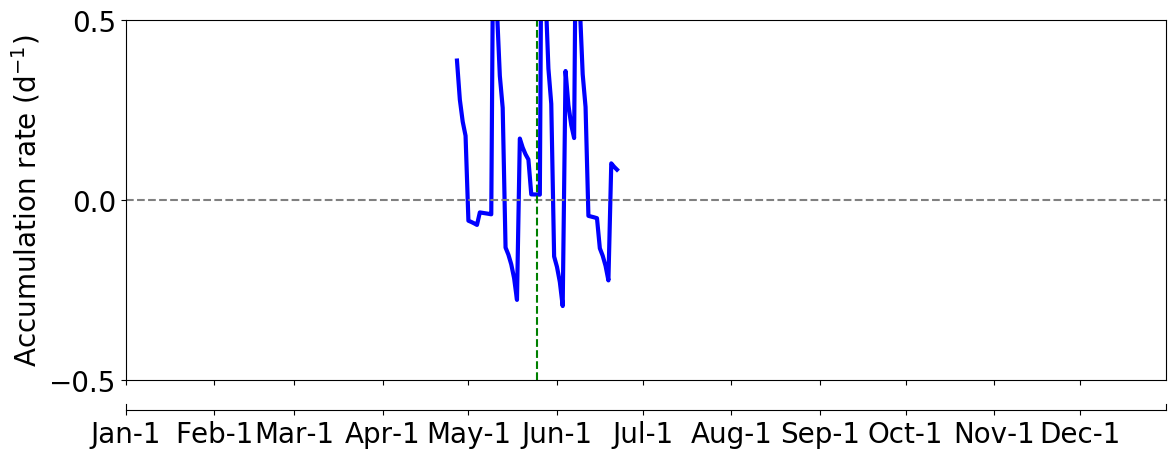

In [43]:
with plt.style.context('mplstyles/exp.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(2,1,sharex=False,figsize=(16, 6))

    # --- ACCUMULATION RATE
    ax=axs[0]
    h1=ax.plot(first_year,array1d_iT_r2011,'-',color='blue',lw=3)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5,1.0,0.5))
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Accumulation rate ($\mathrm{ d^{-1} }$)')
    ax.plot(xlims,[0,0],'k--',color='gray')
    # adding the vertical line at start of bloom development
    ax.axvline(tI-1,color='green',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.15  ,0.65,.60])
    axs[1].set_position( [0.12,0.10  ,0.65,.01])

#### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated) chlorophyll $a$.

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom peak: 2010

In [44]:
tP=np.nanargmax(array1d_iT_chl2010)
tP=tP.item()
year=2010
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tPs=datetime.datetime(year,1,1) + datetime.timedelta(tP)

(in $mg\ Chl\ m^{-2}$)

In [45]:
cP=np.nanmax(array1d_iT_chl2010)

In [46]:
cP

659.6625366210938

Day of year

In [47]:
tP=tP+1
tP

172

In [48]:
tPs.strftime("%B %d")

'June 21'

Since the highest value was the last observation, the chlorophyll $a$ may have continued to increase after the last observation.
It is impossible to know for sure if June 21 was really the bloom peak.

In [49]:
blooms_df.loc[2010,['tP']]=tP
blooms_df.loc[2010,['cP']]=cP

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: date of bloom peak: 2011

In [50]:
tP=np.nanargmax(array1d_iT_chl2011)
tP=tP.item()
year=2011
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tPs=datetime.datetime(year,1,1) + datetime.timedelta(tP)

(in $mg\ Chl\ m^{-2}$)

In [51]:
cP=np.nanmax(array1d_iT_chl2011)

In [52]:
cP

324.3826599121094

Day of year

In [53]:
tP=tP+1
tP

162

In [54]:
tPs.strftime("%B %d")

'June 11'

In [55]:
blooms_df.loc[2011,['tP']]=tP
blooms_df.loc[2011,['cP']]=cP

#### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: $m$

$m$ is the slope between the bloom initiation (I) and the bloom peak (P) in the log scale.
A linear regression of the points between I and P was used.

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: $m$: 2010

In [56]:
obsvintchl2010_df=pd.DataFrame(data={'iT':first_year,
                                     'obsvintchl':array1d_iT_chl2010})
obsvintchl2010_df=obsvintchl2010_df[obsvintchl2010_df.obsvintchl.notna()]

In [57]:
y=2010
tI=blooms_df.loc[y,['tI']].item()-1 # doy (1-based) -> doy (0-based)
tP=blooms_df.loc[y,['tP']].item()-1 # doy (1-based) -> doy (0-based)

Points after bloom initiation and before bloom peak

In [58]:
initiation2010_df=obsvintchl2010_df[(obsvintchl2010_df.iT>=tI)
                                    &(obsvintchl2010_df.iT<=tP)]

Points before bloom initiation and after bloom peak.
Those points were note used for the linear regression.

In [59]:
out2010_df=obsvintchl2010_df[(obsvintchl2010_df.iT<tI)
                             |(obsvintchl2010_df.iT>tP)]

In [60]:
loginitiation2010_df=pd.DataFrame(
    data={'iT':initiation2010_df.iT,
          'obsvintlogchl':np.log10(initiation2010_df.obsvintchl)})
olsres=smf.ols('obsvintlogchl~iT',data=loginitiation2010_df).fit()
m=olsres.params.iT

In [61]:
blooms_df.loc[2010,['m']]=m

To draw the line representing $m$.

In [62]:
olsx2010=[tI,tP]
olsy2010=olsres.predict(pd.DataFrame({'iT':olsx2010}))
olsy2010=np.power(10,olsy2010)

##### Observations Resolute 2010 and 2011: chlorophyll $a$: timing: $m$: 2011

In [63]:
obsvintchl2011_df=pd.DataFrame(data={'iT':first_year,
                                     'obsvintchl':array1d_iT_chl2011})
obsvintchl2011_df=obsvintchl2011_df[obsvintchl2011_df.obsvintchl.notna()]

In [64]:
y=2011
tI=blooms_df.loc[y,['tI']].item()-1 # doy (1-based) -> doy (0-based)
tP=blooms_df.loc[y,['tP']].item()-1 # doy (1-based) -> doy (0-based)

Points after bloom initiation and before bloom peak

In [65]:
initiation2011_df=obsvintchl2011_df[(obsvintchl2011_df.iT>=tI)
                                    &(obsvintchl2011_df.iT<=tP)]

Points before bloom initiation and after bloom peak.
Those points were note used for the linear regression.

In [66]:
out2011_df=obsvintchl2011_df[(obsvintchl2011_df.iT<tI)
                             |(obsvintchl2011_df.iT>tP)]

In [67]:
loginitiation2011_df=pd.DataFrame(
    data={'iT':initiation2011_df.iT,
          'obsvintlogchl':np.log10(initiation2011_df.obsvintchl)})
olsres=smf.ols('obsvintlogchl~iT',data=loginitiation2011_df).fit()
m=olsres.params.iT

In [68]:
blooms_df.loc[2011,['m']]=m

To draw the line representing $m$.

In [69]:
olsx2011=[tI,tP]
olsy2011=olsres.predict(pd.DataFrame({'iT':olsx2011}))
olsy2011=np.power(10,olsy2011)

# Observations Qikiqtarjuaq 2015

## Observations Qikiqtarjuaq 2015: chlorophyll $a$

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations Qikiqtarjuaq 2015: chlorophyll $a$: load dataset

In [70]:
def load_pigment():
    fname='obs/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['depth']=-df['depth'] # negative depths
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [71]:
chlHPLC2015_df=load_pigment()

### Observations Qikiqtarjuaq 2015: chlorophyll $a$: select

We select the observations of chlorophyll $a$ concentrations at the ice camp 2015 measured by HPLC.

In [72]:
chlHPLC2015_df=\
chlHPLC2015_df[(chlHPLC2015_df.mission=='ice_camp_2015') \
               & (chlHPLC2015_df.sample_type=='water') \
               & (chlHPLC2015_df.pigment=='Total Chlorophyll a') \
               & (chlHPLC2015_df.method=='HPLC')]

find negative chlorophyll $a$

In [73]:
chlHPLC2015_df['chlHPLC'][ chlHPLC2015_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

find duplicates

In [74]:
g=chlHPLC2015_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
134  -1.5     3.0
159  -1.5     3.0
Name: depth, dtype: float64

inspect duplicates for doy=134

In [75]:
chlHPLC2015_df[['depth','chlHPLC','doy']]\
[ (chlHPLC2015_df['doy']==134) & (chlHPLC2015_df['depth']==-1.5)]

depth  chlHPLC  doy
10386   -1.5   0.2205  134
10387   -1.5   0.2240  134
10388   -1.5   0.2181  134

replace with the average

In [76]:
mean=(chlHPLC2015_df[['chlHPLC']] \
      [ (chlHPLC2015_df['doy']==134) \
       & (chlHPLC2015_df['depth']==-1.5)]).mean()
mean=mean.iloc[0]

In [77]:
chlHPLC2015_df.loc[(chlHPLC2015_df['doy']==134) \
                   & (chlHPLC2015_df['depth']==-1.5),'chlHPLC']=mean

inspect duplicates for doy=159

In [78]:
chlHPLC2015_df[['depth','chlHPLC','doy']] \
[ (chlHPLC2015_df['doy']==159) & (chlHPLC2015_df['depth']==-1.5)]

depth  chlHPLC  doy
10460   -1.5   0.1700  159
10461   -1.5   0.1684  159
10462   -1.5   0.4612  159

replace with the average

In [79]:
mean=(chlHPLC2015_df[['chlHPLC']] \
      [ (chlHPLC2015_df['doy']==159) \
       & (chlHPLC2015_df['depth']==-1.5)]).mean()
mean=mean.iloc[0]

In [80]:
chlHPLC2015_df.loc[(chlHPLC2015_df['doy']==159) \
                   & (chlHPLC2015_df['depth']==-1.5),'chlHPLC']=mean

In [81]:
chlHPLC2015_df.drop_duplicates(subset=['depth','doy'],inplace=True)

Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [82]:
g=chlHPLC2015_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy  doy
91   91     2.0
93   93     1.0
96   96     1.0
99   99     1.0
102  102    2.0
106  106    2.0
Name: doy, dtype: float64

In [83]:
chlHPLC2015_df[['depth','chlHPLC','doy']] \
[(chlHPLC2015_df.doy==91) | (chlHPLC2015_df.doy==93) \
 | (chlHPLC2015_df.doy==96) | (chlHPLC2015_df.doy==99) \
 | (chlHPLC2015_df.doy==102) | (chlHPLC2015_df.doy==106)]

depth  chlHPLC  doy
10306  -20.0   0.0281   91
10307   -0.5   0.0556   91
10308   -5.0   0.0626   93
10309   -5.0   0.0656   96
10310   -5.0   0.0618   99
10311  -20.0   0.0620  102
10312   -5.0   0.1085  102
10316  -20.0   0.0532  106
10317   -5.0   0.0807  106

By human judgement, I drop these observations.

In [84]:
chlHPLC2015_df=chlHPLC2015_df.drop(
    chlHPLC2015_df[(chlHPLC2015_df.doy==91) | (chlHPLC2015_df.doy==93) \
                   | (chlHPLC2015_df.doy==96) | (chlHPLC2015_df.doy==99) \
                   | (chlHPLC2015_df.doy==102) | (chlHPLC2015_df.doy==106)].index)

### Observations Qikiqtarjuaq 2015: chlorophyll $a$: vertically integrated (0-100m)

in $mg\ Chla\ m^{-2}$

In [85]:
#doy: 104
depths_case1 =np.array([-5,-20,-65])
weights_case1=np.array([12.5,30,57.5])
#doy: 108
depths_case2 =np.array([-1.5,-5,-20])
weights_case2=np.array([3.25,9.25,87.5])
#doy: 110,112,114,116,159,161
depths_case3 =np.array([-1.5,-5,-20,-40,-60])
weights_case3=np.array([3.25,9.25,17.5,20,50])
#doy: 118
depths_case4 =np.array([-0.5,-1.5,-5,-14,-40,-60])
weights_case4=np.array([1,2.25,9.25,17.5,20,50])
#doy: 120,124,126,128,132,134,136,138,140,142,145,147,149,151,153,155,157
depths_case5 =np.array([-0.5,-1.5,-5,-20,-40,-60])
weights_case5=np.array([1,2.25,9.25,17.5,20,50])
#doy: 122
depths_case6 =np.array([-0.5,-1.5,-5,-40,-60])
weights_case6=np.array([1,2.25,19.25,27.5,50])
#doy: 163
depths_case7 =np.array([-0.5,-1.5,-5,-20,-40])
weights_case7=np.array([1,2.25,9.25,17.5,70])
#doy: 166,169
depths_case8 =np.array([-0.5,-5,-10,-20,-40])
weights_case8=np.array([2.75,4.75,7.5,15,70])
#doy: 172,175,178,181,184,189
depths_case9 =np.array([-0.5,-1.5,-5,-10,-20,-40])
weights_case9=np.array([1,2.25,4.25,7.5,15,70])
#doy: 187
depths_case10 =np.array([-0.5,-1.5,-5,-10,-20,-40,-60])
weights_case10=np.array([1,2.25,4.25,7.5,15,20,50])
#doy: 191
depths_case11 =np.array([-1.5,-5,-8,-18,-40])
weights_case11=np.array([3.25,3.25,6.5,16,71])
#doy: 193
depths_case12 =np.array([-1.5,-15,-30])
weights_case12=np.array([8.25,14.25,77.5])
#doy:195
depths_case13 =np.array([-1.5,-5,-30])
weights_case13=np.array([3.25,14.25,82.5])

In [86]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC2015_df[['depth','chlHPLC']] \
    [(chlHPLC2015_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1)==set(depths):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2)==set(depths):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3)==set(depths):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4)==set(depths):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5)==set(depths):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6)==set(depths):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7)==set(depths):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8)==set(depths):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    elif set(depths_case9)==set(depths):
        for depth in depths_case9:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case9)
    elif set(depths_case10)==set(depths):
        for depth in depths_case10:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case10)
    elif set(depths_case11)==set(depths):
        for depth in depths_case11:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case11)
    elif set(depths_case12)==set(depths):
        for depth in depths_case12:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case12)
    elif set(depths_case13)==set(depths):
        for depth in depths_case13:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case13)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

### Observations Qikiqtarjuaq 2015: chlorophyll $a$: timing

#### Observations Qikiqtarjuaq 2015: chlorophyll $a$: timing: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

$In\ situ$ data was smoothed with LOWESS (locally weighted scatterplot smoothing) and interpolated before calculating the accumulation rates.

For $in\ situ$ data, by applying the definition of Boss & Behrenfeld (2010) of 7 days with a positive accumulation rate ($d^{-1}$), the date of bloom initiation would have been April 21.
This date was questionable because there was no continuous increase of Chl $a$.
This was an indication that human judgment was needed to identify the date of the bloom initiation.
We supposed that the small peak observable on April 18 and even the larger one observed on May 12 may not be due to local phytoplankton but instead to the flushing of sea ice algae or to the horizontal advection of phytoplankton.
The algorithm was applied after May 12 and found a date of bloom initiation on June 7.
Note that Oziel et al. (2019) in $Elem.\ Sci\ Anth.$ also found a date of bloom initiation at the start of June from the same observations.

In [87]:
x=first_year
y=array1d_iT_obsvintchlHPLC
df=pd.DataFrame({'Day of year':x,'Observed Chl a vert. integrated (0-100m)':y})

In [88]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

Figure. Scatterplot of day of year and observed Chl a vert. integrated (0-100m).

In [89]:
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/4)

In [90]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add the prediction line
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS, frac=1/4', line=dict(color='red')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

In [91]:
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False) 

# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
    
# Find y values based on the interpolation method
array1d_iT_obsvintchlHPLClowess=f_linear(xnew)

start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_obsvintchlHPLClowess=np.concatenate((start_edge,
                                                array1d_iT_obsvintchlHPLClowess,
                                                end_edge))

In [92]:
x=first_year
y=array1d_iT_obsvintchlHPLClowess
df=pd.DataFrame({'Day of year':x,'Smoothed and interpolated observed Chl a vert. integrated (0-100m)':y})

In [93]:
indices_not_nan=np.argwhere(~np.isnan(array1d_iT_obsvintchlHPLClowess)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
# no NaN between first and last smoothed observed value
assert np.array_equal(indices_not_nan,np.arange(start,end+1)), (
    'There is at least one NaN in array1d_iT_obsvintchlHPLCsmooth before '
    'its first and last valid values.')
array1d_iT_r2015=np.empty(365)
array1d_iT_r2015[:]=np.NaN
for iT in range(start+1,end):
    chliT=array1d_iT_obsvintchlHPLClowess[iT]
    chljT=array1d_iT_obsvintchlHPLClowess[iT-1]
    acc=(chliT-chljT)/chljT
    array1d_iT_r2015[iT]=acc

In [94]:
x=first_year
y=array1d_iT_r2015
df=pd.DataFrame({'Day of year':x,'Accumulation rates':y})

In [95]:
found=False
iT=138 # starting after the small peak of 131 (May 12) + 7
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_r2015[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
tI=iT
year=2015 # any non-leap year
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tIs=datetime.datetime(year,1,1) + datetime.timedelta(tI)

Day of year

In [96]:
tI=tI+1
tI

158

In [97]:
tIs.strftime("%B %d")

'June 07'

In [98]:
cI=array1d_iT_obsvintchlHPLClowess[tI-1]

(in $mg\ Chl\ m^{-2}$)

In [99]:
cI

6.280748298393588

In [100]:
blooms_df.loc[2015,['tI']]=tI
blooms_df.loc[2015,['cI']]=cI

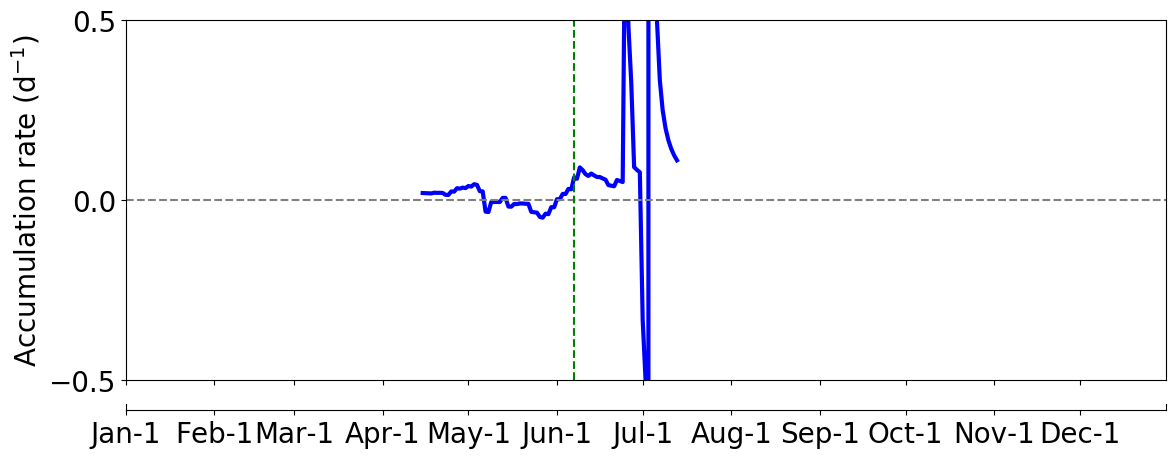

In [101]:
with plt.style.context('mplstyles/exp.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(2,1,sharex=False,figsize=(16, 6))

    # --- ACCUMULATION RATE
    ax=axs[0]
    h1=ax.plot(first_year,array1d_iT_r2015,'-',color='blue',lw=3)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5,1.0,0.5))
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Accumulation rate ($\mathrm{ d^{-1} }$)')
    ax.plot(xlims,[0,0],'k--',color='gray')
    # adding the vertical line at start of bloom development
    ax.axvline(tI-1,color='green',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.15  ,0.65,.60])
    axs[1].set_position( [0.12,0.10  ,0.65,.01])

#### Observations Qikiqtarjuaq 2015: chlorophyll $a$: timing: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated) chlorophyll $a$.

In [102]:
tP=np.nanargmax(array1d_iT_obsvintchlHPLC)
tP=tP.item()
year=2015
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tPs=datetime.datetime(year,1,1) + datetime.timedelta(tP)

(in $mg\ Chl\ m^{-2}$)

In [103]:
cP=np.nanmax(array1d_iT_obsvintchlHPLC)

In [104]:
cP

314.64061871171

Day of year

In [105]:
tP=tP+1
tP

195

In [106]:
tPs.strftime("%B %d")

'July 14'

In [107]:
blooms_df.loc[2015,['tP']]=tP
blooms_df.loc[2015,['cP']]=cP

#### Observations Qikiqtarjuaq 2015: chlorophyll $a$: timing: $m$

$m$ is the slope between the bloom initiation (I) and the bloom peak (P) in the log scale.
A linear regression of the points between I and P was used.

In [108]:
obsvintchl2015_df=pd.DataFrame(data={'iT':first_year,
                                     'obsvintchl':array1d_iT_obsvintchlHPLC})
obsvintchl2015_df=obsvintchl2015_df[obsvintchl2015_df.obsvintchl.notna()]

In [109]:
y=2015
tI=blooms_df.loc[y,['tI']].item()-1 # doy (1-based) -> doy (0-based)
tP=blooms_df.loc[y,['tP']].item()-1 # doy (1-based) -> doy (0-based)

Points after bloom initiation and before bloom peak

In [110]:
initiation2015_df=obsvintchl2015_df[(obsvintchl2015_df.iT>=tI)
                                    &(obsvintchl2015_df.iT<=tP)]

Points before bloom initiation and after bloom peak.
Those points were note used for the linear regression.

In [111]:
out2015_df=obsvintchl2015_df[(obsvintchl2015_df.iT<tI)
                             |(obsvintchl2015_df.iT>tP)]

In [112]:
loginitiation2015_df=pd.DataFrame(
    data={'iT':initiation2015_df.iT,
          'obsvintlogchl':np.log10(initiation2015_df.obsvintchl)})
olsres=smf.ols('obsvintlogchl~iT',data=loginitiation2015_df).fit()
m=olsres.params.iT

In [113]:
blooms_df.loc[2015,['m']]=m

To draw the line representing $m$.

In [114]:
olsx2015=[tI,tP]
olsy2015=olsres.predict(pd.DataFrame({'iT':olsx2015}))
olsy2015=np.power(10,olsy2015)

# Observations Qikiqtarjuaq 2016

## Observations Qikiqtarjuaq 2016: ice concentration

Break-up was on 18 July 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [115]:
obsice=np.empty(365)
obsice[:]=np.NaN
obsice[0:199]=1
obsice[199]=0

Day of *in situ* sea ice break-up:

In [116]:
obs_breakup=next(i for i,v in enumerate(obsice) if v < 0.50)

## Observations Qikiqtarjuaq 2016: nutrients

The file Nutrients from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ nutrients at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'no3_um_l', 'po4_um_l', and 'sioh4_um_l' are the nitrate, phosphate, and silicic acid concentrations, respectively ($\mathrm{ \mu }$M).

### Observations Qikiqtarjuaq 2016: nutrients: load dataset

In [117]:
def load_nutrients():
    fname='data/DataS2_observations_Qikiqtarjuaq/66412.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'bottom_depth_m': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'filter_type': 'category',
                'quality_flag': 'category',
                'dilution_factor': np.float32,
                'no3_um_l': np.float32,
                'no2_um_l': np.float32,
                'no2_and_no3': np.float32,
                'po4_um_l': np.float32,
                'sioh4_um_l': np.float32,
                'n_ice_samples_ice_camp_2016': np.float32,
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                no3_um_l='no3',
                po4_um_l='po4',
                sioh4_um_l='sioh4'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [118]:
nutrients_df=load_nutrients()

### Observations Qikiqtarjuaq 2016: nutrients: select

We select the observations of nitrate at the ice camp 2016 in the water column made with a GFF filter.

In [119]:
nutrients_df=nutrients_df[(nutrients_df.mission=='ice_camp_2016') \
              & (nutrients_df.sample_type=='water') \
             & (nutrients_df.filter_type=='gff')]

Find duplicates.

In [120]:
g=nutrients_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: depth, dtype: float64)

No duplicates.

## Observations Qikiqtarjuaq 2016: chlorophyll *a*

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations Qikiqtarjuaq 2016: chlorophyll *a* load dataset

In [121]:
def load_pigment():
    fname='data/DataS2_observations_Qikiqtarjuaq/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [122]:
chlHPLC_df=load_pigment()

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [123]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

remove negative chlorophyll a

In [124]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

find duplicates

In [125]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: depth, dtype: float64

inspect duplicates for doy=146

In [126]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20357    0.5   0.1056  146
20358    1.5   0.0899  146
20359    5.0   0.0906  146
20360   10.0   0.0905  146
20361   20.0   0.1011  146
20362   40.0   0.0633  146
20363    0.5   0.0971  148
20364    1.5   0.1483  146
20365    5.0   0.1086  148
20366   10.0   0.0890  146
20367   20.0   0.0735  148
20368   40.0   0.0399  148

By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [127]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [128]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20357    0.5   0.1056  146
20358    1.5   0.0899  146
20359    5.0   0.0906  146
20360   10.0   0.0905  146
20361   20.0   0.1011  146
20362   40.0   0.0633  146
20363    0.5   0.0971  148
20364    1.5   0.1483  148
20365    5.0   0.1086  148
20366   10.0   0.0890  148
20367   20.0   0.0735  148
20368   40.0   0.0399  148

Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [129]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy  doy
120  120    2.0
Name: doy, dtype: float64

In [130]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20299    1.5   0.0355  120
20300    5.0   0.0253  120

By human judgement, I drop these observations.

In [131]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: vertically integrated chlorophyll *a* (0-40m)

in $\mathrm{ mg\ Chl\ m^{-2} }$

In [132]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    10])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  10])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    10])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         15])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    10])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,15,     0])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,15,     0,   0])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45, 60])
weights_case8=np.array([     5.75,        9.25,10,12.5, 2.5,0])

In [133]:
nT=365
array1d_iT_obsvint40mchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvint40mchlHPLC[iT]=obsvintchlHPLC

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [134]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [135]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

### Observations Qikiqtarjuaq 2016: chlorophyll $a$: mean chlorophyll a (0-40m)

in $mg\ Chla\ m^{-3}$

In [136]:
#doy: 123
depths_case1 =np.array([       1.5,  5,    10,    20,     40])
weights_case1=np.array([       3.25, 4.25,  7.5,  15,     10])
#doys: 125,127
depths_case2 =np.array([ 0.5,  1.5,  5,           20,     40])
weights_case2=np.array([ 1,    2.25, 9.25,         17.5,  10])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([ 0.5, 1.5,   5,    10,    20,     40])
weights_case3=np.array([ 1,   2.25,  4.25,  7.5,  15,     10])
#doy: 141
depths_case4 =np.array([ 0.5, 1.5,   5,    10,            40])
weights_case4=np.array([ 1,   2.25,  4.25, 17.5,          15])
#doy: 174
depths_case5 =np.array([ 0.5, 1.5,         10,    20,     40])
weights_case5=np.array([ 1,   4.75,         9.25, 15,     10])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([ 0.5, 1.5,         10,    20, 30,     60])
weights_case6=np.array([ 1,   4.75,         9.25, 10, 15,      0])
#doys: 193,195,200
depths_case7 =np.array([      1.5,         10,    20, 30,     60,   75])
weights_case7=np.array([      5.75,         9.25, 10, 15,      0,    0])
#doys: 197,204
depths_case8 =np.array([      1.5,         10,    20, 30,   45, 60])
weights_case8=np.array([      5.75,         9.25, 10, 12.5, 2.5,  0])

In [137]:
nT=365
array1d_iT_obsmeanchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsmeanchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case8)
    array1d_iT_obsmeanchlHPLC[iT]=obsmeanchlHPLC

### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing

#### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

$In\ situ$ data was smoothed with LOWESS (locally weighted scatterplot smoothing) and interpolated before calculating the accumulation rates.

For $in\ situ$ data, by applying the definition of Boss & Behrenfeld (2010) of 7 days with a positive accumulation rate ($d^{-1}$), the date of bloom initiation would have been May 9.
This date was questionable because light was low on May 9, there was no continuous decrease of nutrients and there was no continuous increase of Chl $a$.
Also, changing the number of days with a positive accumulation rate from 7 days to 8 days changed the date of bloom initiation from May 9 to May 30 indicating a high sensitivity on the number of days with a positive accumulation rate.
This was an indication that human judgment was needed to identify the date of the bloom initiation.
We supposed that the small peak observable on May 9 may not be due to local phytoplankton but instead to the flushing of sea ice algae or to the horizontal advection of phytoplankton.
The algorithm was applied after May 9 and found a date of bloom initiation on May 30.
Note that Oziel et al. (2019) in $Elem.\ Sci\ Anth.$ also found a date of bloom initiation at the end of May from the same observations.

In [138]:
x=first_year
y=array1d_iT_obsvintchlHPLC
df=pd.DataFrame({'Day of year':x,'Observed Chl a vert. integrated (0-100m)':y})

In [139]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

Figure. Scatterplot of day of year and observed Chl a vert. integrated (0-100m).

In [140]:
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/4)

In [141]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add the prediction line
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS, frac=1/4', line=dict(color='red')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

In [142]:
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False) 

# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
    
# Find y values based on the interpolation method
array1d_iT_obsvintchlHPLClowess=f_linear(xnew)

start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_obsvintchlHPLClowess=np.concatenate((start_edge,
                                                array1d_iT_obsvintchlHPLClowess,
                                                end_edge))

In [143]:
x=first_year
y=array1d_iT_obsvintchlHPLClowess
df=pd.DataFrame({'Day of year':x,'Smoothed and interpolated observed Chl a vert. integrated (0-100m)':y})

In [144]:
indices_not_nan=np.argwhere(~np.isnan(array1d_iT_obsvintchlHPLClowess)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
# no NaN between first and last smoothed observed value
assert np.array_equal(indices_not_nan,np.arange(start,end+1)), (
    'There is at least one NaN in array1d_iT_obsvintchlHPLCsmooth before '
    'its first and last valid values.')
array1d_iT_r2016=np.empty(365)
array1d_iT_r2016[:]=np.NaN
for iT in range(start+1,end):
    chliT=array1d_iT_obsvintchlHPLClowess[iT]
    chljT=array1d_iT_obsvintchlHPLClowess[iT-1]
    acc=(chliT-chljT)/chljT
    array1d_iT_r2016[iT]=acc

In [145]:
x=first_year
y=array1d_iT_r2016
df=pd.DataFrame({'Day of year':x,'Accumulation rates':y})

In [146]:
found=False
iT=136 # starting after the small peak of 129 (May 9) + 7
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_r2016[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
tI=iT
year=2016 # any leap year
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tIs=datetime.datetime(year,1,1) + datetime.timedelta(tI)

Day of year

In [147]:
tI=tI+1
tI

148

In [148]:
tIs.strftime("%B %d")

'May 27'

In [149]:
cI=array1d_iT_obsvintchlHPLClowess[tI-1]

(in $mg\ Chl\ m^{-2}$)

In [150]:
cI

6.412508830445615

In [151]:
blooms_df.loc[2016,['tI']]=tI
blooms_df.loc[2016,['cI']]=cI

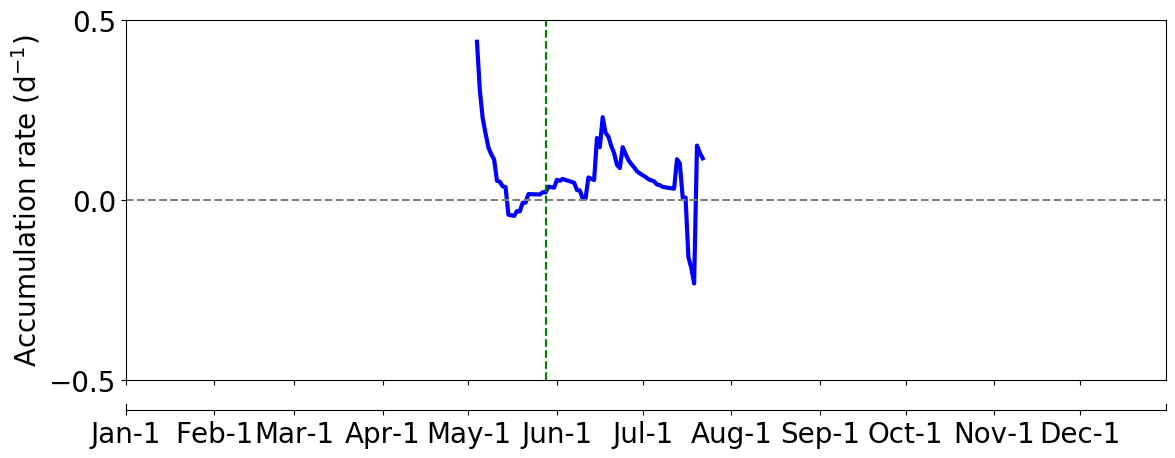

In [152]:
with plt.style.context('mplstyles/exp.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(2,1,sharex=False,figsize=(16, 6))

    # --- ACCUMULATION RATE
    ax=axs[0]
    h1=ax.plot(first_year,array1d_iT_r2016,'-',color='blue',lw=3)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5,1.0,0.5))
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Accumulation rate ($\mathrm{ d^{-1} }$)')
    ax.plot(xlims,[0,0],'k--',color='gray')
    # adding the vertical line at start of bloom development
    ax.axvline(tI-1,color='green',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.15  ,0.65,.60])
    axs[1].set_position( [0.12,0.10  ,0.65,.01])

#### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated) chlorophyll $a$.

In [153]:
tP=np.nanargmax(array1d_iT_obsvintchlHPLC)
tP=tP.item()
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tPs=datetime.datetime(year,1,1) + datetime.timedelta(tP)

(in $mg\ Chl\ m^{-2}$)

In [154]:
cP=np.nanmax(array1d_iT_obsvintchlHPLC)

In [155]:
cP

204.44257855415344

Day of year

In [156]:
tP=tP+1
tP

197

In [157]:
tPs.strftime("%B %d")

'July 15'

In [158]:
blooms_df.loc[2016,['tP']]=tP
blooms_df.loc[2016,['cP']]=cP

#### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing: $m$

$m$ is the slope between the bloom initiation (I) and the bloom peak (P) in the log scale.
A linear regression of the points between I and P was used.

In [159]:
obsvintchl2016_df=pd.DataFrame(data={'iT':first_year,
                                     'obsvintchl':array1d_iT_obsvintchlHPLC})
obsvintchl2016_df=obsvintchl2016_df[obsvintchl2016_df.obsvintchl.notna()]

In [160]:
y=2016
tI=blooms_df.loc[y,['tI']].item()-1 # doy (1-based) -> doy (0-based)
tP=blooms_df.loc[y,['tP']].item()-1 # doy (1-based) -> doy (0-based)

Points after bloom initiation and before bloom peak

In [161]:
initiation2016_df=obsvintchl2016_df[(obsvintchl2016_df.iT>=tI)
                                    &(obsvintchl2016_df.iT<=tP)]

Points before bloom initiation and after bloom peak.
Those points were note used for the linear regression.

In [162]:
out2016_df=obsvintchl2016_df[(obsvintchl2016_df.iT<tI)
                             |(obsvintchl2016_df.iT>tP)]

In [163]:
loginitiation2016_df=pd.DataFrame(
    data={'iT':initiation2016_df.iT,
          'obsvintlogchl':np.log10(initiation2016_df.obsvintchl)})
olsres=smf.ols('obsvintlogchl~iT',data=loginitiation2016_df).fit()
m=olsres.params.iT

In [164]:
blooms_df.loc[2016,['m']]=m

To draw the line representing $m$.

In [165]:
olsx2016=[tI,tP]
olsy2016=olsres.predict(pd.DataFrame({'iT':olsx2016}))
olsy2016=np.power(10,olsy2016)

# Output from model CGRF

input file: 1D_GDPS_qsw_y2016.nc

name: qsw

Variable qsw is the shortwave radiation just above surface. It is at indices (2,2) meaning center of grid point was used. File 1D_GDPS_qsw_y2016.nc is the output of CMC GDPS reforecasts (CGRF, Smith et al., 2014, https://doi.org/10.1002/qj.2194.) CMC: Canadian Meteorological Centre's. GDPS: global deterministic prediction system. The data was provided by Gregory Smith (Environment Canada). Gaetan Olivier (UBO) preprocessed it to get the data at the Green Edge 2016 ice camp (67.48N, -63.79E).

The goal was to calculate PAR just below open water
($I_w(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)
from shortwave radiation just above surface
($Q(0^+)$, $\mathrm{ W\ m^{-2} }$).

## Output from model CGRF: daily shortwave radiation just above surface ($Q(0^+)$, $\mathrm{ W\ m^{-2} }$)

In [166]:
ndays=365
first_year=np.arange(0,ndays)

In [167]:
qswow_file='data/DataS6_output_cgrf/1D_GDPS_qsw_y2016.nc'
array1d_iT_qswowabovehourly=netcdf_tools.read_netcdf(qswow_file,'qsw')
array1d_iT_qswowabovehourly=array1d_iT_qswowabovehourly[:,1,1]
array1d_idoy_qswowabove=np.zeros(ndays)
for idoy in first_year:
    qswowabovedaily=0
    for iT in np.arange(idoy*24,(idoy+1)*24):
        qswowabovedaily=qswowabovedaily+array1d_iT_qswowabovehourly[iT]
    qswowabovedaily=qswowabovedaily/24
    array1d_idoy_qswowabove[idoy]=qswowabovedaily

## Output from model CGRF: daily shortwave radiation just below open water ($Q_w(0^-)$, $\mathrm{ W\ m^{-2} }$)

In [168]:
albedo=0.066 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_qswow=array1d_idoy_qswowabove*(1-albedo)

## Output from model CGRF: daily PAR just below open water ($I_w(0^-)$, $\mathrm{ W\ m^{-2} }$)

In [169]:
Wm2_to_PAR=0.43 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_PARow=array1d_idoy_qswow*Wm2_to_PAR

## Output from model CGRF: daily irradiance of each 3 RGB band just below open water ($E_w(0^-)$, $\mathrm{ W\ m^{-2} }$)

In [170]:
onecolor=1/3
array1d_idoy_blueWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_greenWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_redWm2ow=array1d_idoy_PARow*onecolor

## Output from model CGRF: daily irradiance of each 3 RGB band just below open water ($E_w(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

ref: https://gud.mit.edu/MITgcm/source/pkg/gud/gud_radtrans_direct.F?v=gud

In [171]:
rmus=1/0.83
planck = 6.6256e-34  # Plancks constant J sec
c = 2.998e8          # speed of light m/sec
hc = 1.0/(planck*c)
oavo = 1.0/6.023e23  # 1/Avogadros number
hcoavo = hc*oavo
wb_center=np.array([450,550,650]) # [blue, green, red]
rlamm=wb_center*1e-9 # lambda in m
WtouEins=1e6*rlamm*hcoavo

In [172]:
array1d_idoy_blueow =array1d_idoy_blueWm2ow *WtouEins[0]
array1d_idoy_greenow=array1d_idoy_greenWm2ow*WtouEins[1]
array1d_idoy_redow  =array1d_idoy_redWm2ow  *WtouEins[2]

## Output from model CGRF: daily PAR just below open water ($I_w(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [173]:
array1d_idoy_PARowuEin=array1d_idoy_blueow+array1d_idoy_greenow+array1d_idoy_redow

# Output from model NEMO-LIM3

## Output from model NEMO-LIM3: sea ice concentration

The file siarea.nemo.2016.365.32bits.bin contains data from a simulation of NEMO3.6 LIM3.6 configured by Gaetan Olivier (UBO) for the Qikiqtarjuaq sea ice camp location ($67.48^\circ N$, $-63.79^\circ E$) in 2016. It contains sea ice concentration (unitless).

In [174]:
ice=np.fromfile('data/DataS4_output_nemo_lim3/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

## Output from model NEMO-LIM3: light

input file: GE_mod_var.nc.

long_name: solar_heat_flux_under_ice_for_100:100_ice_cover.

standard_name in NEMO: surface_downwelling_shortwave_in water.

Variable solar_heat_flux_under_ice_for_100:100_ice_cover is the surface
downwelling shortwave in water (below ice for 100% ice cover).
It is at indices (2,2) meaning center of grid point was used.
File GE_mod_var.nc is the output of NEMO3.6+LIM3.6 model configured 
by Gaetan Olivier (UBO) for the Green Edge ice camp 2016
(67.48N, -63.79E).

NEMO3.6: Madec et al., 2017:   http://hdl.handle.net/2122/13309.

LIM3.6:  Rousset et al., 2015: doi:10.5194/gmdd-8-3403-2015.

The goal was to calculate PAR just below sea ice
($I_i(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)
from shortwave radiation just below sea ice
($Q_i(0^-)$, $\mathrm{ W\ m^{-2} }$).

### Output from model NEMO-LIM3: daily shortwave radiation just below sea ice in 2016 ($Q_i(0^-)$, $\mathrm{ W\ m^{-2} }$)

from 2013 to 2017

In [175]:
qswice_file='data/DataS4_output_nemo_lim3/GE_mod_var.nc'
array1d_iT_qswicefull=netcdf_tools.read_netcdf(qswice_file,'solar heat flux under ice for 100:100 ice cover')
array1d_iT_qswicefull=array1d_iT_qswicefull[:,1,1]

in 2016

In [176]:
array1d_idoy_qswice=array1d_iT_qswicefull[365*3:365*4]

### Output from model NEMO-LIM3: daily PAR just below sea ice in 2016 ($I_i(0^-)$, $\mathrm{ W\ m^{-2} }$)

In [177]:
Wm2_to_PAR=0.85 # Lebrun et al. (submitted)
array1d_idoy_PARice=array1d_idoy_qswice*Wm2_to_PAR

### Output from model NEMO-LIM3: daily irradiance of each 3 RGB band just below sea ice in 2016 ($E_i(0^-)$, $\mathrm{ W\ m^{-2} }$)

In [178]:
# Lebrun et al. (submitted). Values for the Green Edge ice camp 2016.
blue_fraction =0.43
green_fraction=0.46
red_fraction =0.11
array1d_idoy_blueWm2 =array1d_idoy_PARice*blue_fraction
array1d_idoy_greenWm2=array1d_idoy_PARice*green_fraction
array1d_idoy_redWm2  =array1d_idoy_PARice*red_fraction

### Output from model NEMO-LIM3: daily irradiance of each 3 RGB band just below sea ice in 2016 ($E_i(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [179]:
array1d_idoy_blue =array1d_idoy_blueWm2 *WtouEins[0]
array1d_idoy_green=array1d_idoy_greenWm2*WtouEins[1]
array1d_idoy_red  =array1d_idoy_redWm2  *WtouEins[2]

### Output from model NEMO-LIM3: daily PAR just below sea ice in 2016 ($I_i(0^-)$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [180]:
array1d_idoy_PARiceuEin=array1d_idoy_blue+array1d_idoy_green \
+array1d_idoy_red
array1d_idoy_PARiceuEin=array1d_idoy_PARiceuEin.squeeze()

## Output from model NEMO-LIM3: sea ice concentration

The file siarea.nemo.2016.365.32bits.bin contains data from a simulation of NEMO3.6+LIM3.6 configured by Gaetan Olivier (UBO) for the Qikiqtarjuaq sea ice camp location (67.48N, -63.79E) in 2016. It contains sea ice concentration (unitless).

In [181]:
ice=np.fromfile('data/DataS4_output_nemo_lim3/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

# Model

## Model: traits

### Model: traits: set indir

In [182]:
indir='data/DataS8_output_mitgcm/exp0'

### Model: traits: create RunInfo object

In [183]:
info=gudinfo.RunInfo(indir)

### Model: traits: Cell nutrient uptake half saturation constant on nitrate ($K_{NO_3}$, $\mathrm{ mmol\ N\ m^{-3} }$)

$K_{NO_3}=a_{K_{NO_3}}V^{b_{K_{NO_3}}}$

In [184]:
nplk=info.nplk
K=np.empty(nplk)
K[:]=np.nan
a_kn_no3=info.params['a_kn_no3'] # in mmol N m^3
vol=info.f['vol'] # in um^3
b_kn_no3=info.params['b_kn_no3'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        K[iplk]=a_kn_no3[grp]*vol[iplk]**b_kn_no3[grp]

### Model: traits:  Cell minimum stoichiometric quotas of nitrogen relative to carbon ($Q^{min}_N$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1} }$)

$Q^{min}_{N}=a_{Q^{min}_{N}}V^{b_{Q^{min}_{N}}}$

In [185]:
nplk=info.nplk
Q_min=np.empty(nplk)
Q_min[:]=np.nan
a_qmin_n=info.params['a_qmin_n'] # in mmol N (mmol C)^-1
vol=info.f['vol'] # in um^3
b_qmin_n=info.params['b_qmin_n'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        Q_min[iplk]=a_qmin_n[grp]*vol[iplk]**b_qmin_n[grp]

### Model: traits:  Cell  nutrient uptake rate of nitrate relative to carbon ($V^{max}_{NO_3}$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1}\ d^{-1} }$)

$V^{max}_{NO_3}=a_{V^{max}_{NO_3}}V^{b_{V^{max}_{NO_3}}}$

In [186]:
nplk=info.nplk
V_max_d=np.empty(nplk)
V_max_d[:]=np.nan
a_vmax_no3_s=info.params['a_vmax_no3'] # in mmol N (mmol C)^-1 s^-1
a_vmax_no3_d=a_vmax_no3_s*86400        # in mmol N (mmol C)^-1 d^-1
vol=info.f['vol'] # in um^3
b_vmax_no3=info.params['b_vmax_no3'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        V_max_d[iplk]=a_vmax_no3_d[grp]*vol[iplk]**b_vmax_no3[grp]

## Model: nutrients

In [187]:
carfile='data/DataS8_output_mitgcm/exp0/car.0000000000.t001.nc'

In [188]:
array2d_idepth_iT_modno3full=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
array2d_idepth_iT_modno3=array2d_idepth_iT_modno3full[:,array1d_iT1y_iT]
array2d_idepth_iT_modsioh4full=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
array2d_idepth_iT_modsioh4=array2d_idepth_iT_modsioh4full[:,array1d_iT1y_iT]
array2d_idepth_iT_modpo4full=netcdf_tools.read_netcdf(carfile, 'TRAC05').squeeze().transpose()
array2d_idepth_iT_modpo4=array2d_idepth_iT_modpo4full[:,array1d_iT1y_iT]

### Model: nutrients: on grid for the observations

The values at -0.51 m on the model grid are extrapolated to 0 m. It is the only extrapolation.

In [189]:
array1d_iobs_no3mod=list()
for iobs,row in nutrients_df.iterrows():
    doy=row['doy']
    depthobs=row['depth']
    assert depthobs>=0, \
    "depthobs is negative: %r" %(depthobs)
    assert depthobs<RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC,
        array2d_idepth_iT_modno3[:,doy-1].flatten(),
        bounds_error=False,
        fill_value="extrapolate"
    )
    no3mod=y_interp(depthobs).item()
    array1d_iobs_no3mod.append(no3mod)
no3mod_df=pd.DataFrame({
    'depth':nutrients_df['depth'],
    'no3mod':array1d_iobs_no3mod,
    'doy':nutrients_df['doy']
})

In [190]:
array1d_iobs_sioh4mod=list()
for iobs,row in nutrients_df.iterrows():
    doy=row['doy']
    depthobs=row['depth']
    assert depthobs>=0, \
    "depthobs is positive: %r" %(depthobs)
    assert depthobs<RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC,
        array2d_idepth_iT_modsioh4[:,doy-1].flatten(),
        bounds_error=False,
        fill_value="extrapolate"
    )
    sioh4mod=y_interp(depthobs).item()
    array1d_iobs_sioh4mod.append(sioh4mod)
sioh4mod_df=pd.DataFrame({
    'depth':nutrients_df['depth'],
    'sioh4mod':array1d_iobs_sioh4mod,
    'doy':nutrients_df['doy']
})

In [191]:
array1d_iobs_po4mod=list()
for iobs,row in nutrients_df.iterrows():
    doy=row['doy']
    depthobs=row['depth']
    assert depthobs>=0, \
    "depthobs is positive: %r" %(depthobs)
    assert depthobs<RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC,
        array2d_idepth_iT_modpo4[:,doy-1].flatten(),
        bounds_error=False,
        fill_value="extrapolate"
    )
    po4mod=y_interp(depthobs).item()
    array1d_iobs_po4mod.append(po4mod)
po4mod_df=pd.DataFrame({
    'depth':nutrients_df['depth'],
    'po4mod':array1d_iobs_po4mod,
    'doy':nutrients_df['doy']
})

## Model: chlorophyll *a*

In [192]:
chlfile='data/DataS8_output_mitgcm/exp0/chl.0000000000.t001.nc'

In [193]:
array2d_idepth_iT_modchlfull=\
read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

### Model: chlorophyll $a$: on grid for the observations by HPLC

In [194]:
array1d_iobs_chlmod=list()
for iobs,row in chlHPLC_df.iterrows():
    doy=row['doy']
    depthobs=row['depth']
    assert depthobs>0, \
    "depthobs is not negative: %r" %(depthobs)
    assert depthobs<RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC,
        array2d_idepth_iT_modchl[:,doy-1].flatten(),
        bounds_error=False,
        fill_value="extrapolate"
    )
    chlmod=y_interp(depthobs).item()
    array1d_iobs_chlmod.append(chlmod)
chlmod_df=pd.DataFrame({
    'depth':chlHPLC_df['depth'],
    'chlmod':array1d_iobs_chlmod,
    'doy':chlHPLC_df['doy']
})

### Model: chlorophyll *a*: vertically integrated chlorophyll *a* (0-40m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [195]:
array1d_iT_modvint40mchl=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modchl,
    array1d_idepth_delR=drF,
    depth_end=40)

### Model: chlorophyll *a*: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [196]:
array1d_iT_modvintchl=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modchl,
    array1d_idepth_delR=drF,
    depth_end=100)

### Model: chlorophyll *a*: mean chlorophyll *a* (0-40m)

in $\mathrm{ mg\ Chla\ m^{-3} }$

In [197]:
array1d_iT_modmeanchl=vstats.mean(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modchl,
    array1d_idepth_delR=drF,
    depth_end=40)

## Model: biomass

In [198]:
biofile='data/DataS8_output_mitgcm/exp0/car.0000000000.t001.nc'

In [199]:
array2d_idepth_iT_modphytobiofull=\
read_mitgcm.get_array2d_idepth_iT_phytobiofull(biofile)
array2d_idepth_iT_modphytobio=\
array2d_idepth_iT_modphytobiofull[:,array1d_iT1y_iT]

### Model: biomass: vertically integrated biomass (0-40m)

in $\mathrm{ mg\ C\ m^{-2} }$

In [200]:
array1d_iT_modvint40mphytobio=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modphytobio,
    array1d_idepth_delR=drF,
    depth_end=40)

### Model: biomass: vertically integrated biomass (0-100m)

in $\mathrm{ mg\ C\ m^{-2} }$

In [201]:
array1d_iT_modvintphytobio=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modphytobio,
    array1d_idepth_delR=drF,
    depth_end=100)

### Model: biomass: mean biomass (0-40m)

in $\mathrm{ mg\ C\ m^{-3} }$

In [202]:
array1d_iT_modmeanphytobio=vstats.mean(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modphytobio,
    array1d_idepth_delR=drF,
    depth_end=40)

# Plot

## Plot: traits

In [203]:
type_id=np.arange(1,52)

pos_Prochlorococcus=np.arange( 0, 1)
pos_Synechococcus  =np.arange( 1, 2)
pos_smalleuk       =np.arange( 2, 4)
pos_cocco          =np.arange( 4, 9)
pos_diazo          =np.arange( 9,13)
pos_Trichodesmium  =np.arange(13,14)
pos_diatoms        =np.arange(14,23)
pos_mixodino       =np.arange(23,33)
pos_zoo            =np.arange(33,49)

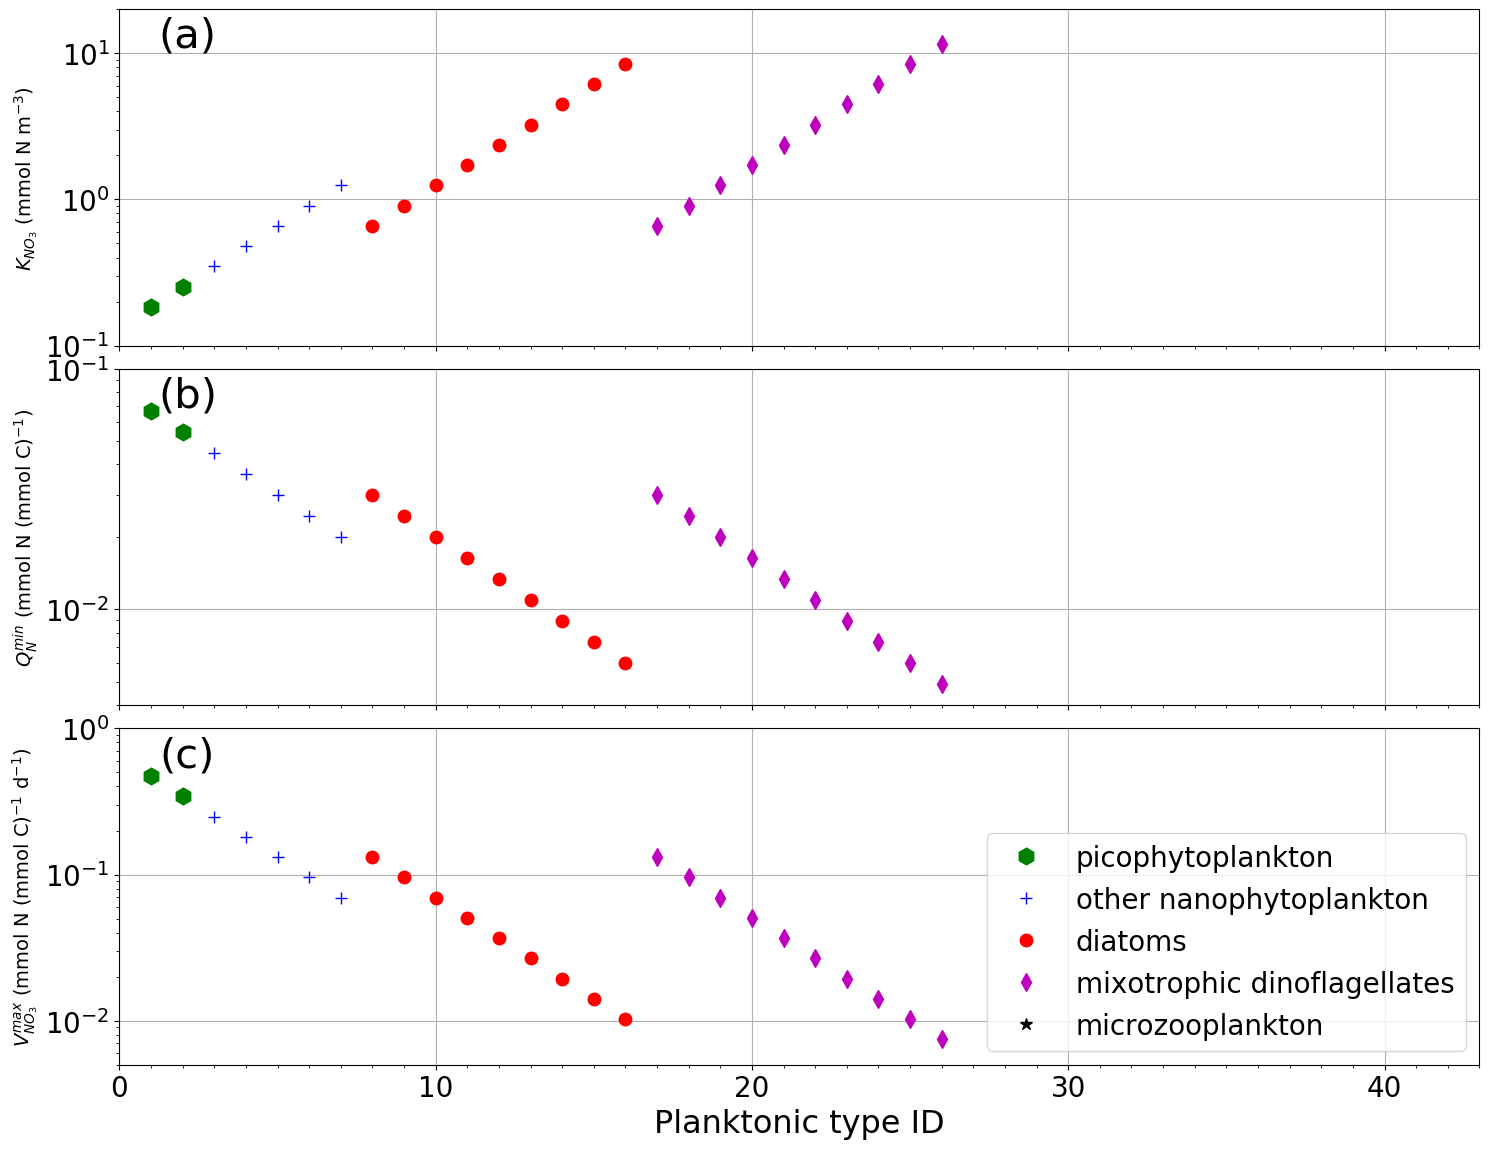

In [204]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    
    # --- CELL NUTRIENT UPTAKE HALF SATURATION CONSTANT ON NITRATE
    ax=axs[0]
    h3=ax.plot(type_id[pos_smalleuk]-2,  K[pos_smalleuk],'gh',
               markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     K[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, K[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,K[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     K[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$K_{NO_3}\ (\mathrm{ mmol\ N\ m^{-3} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.1,20])
    ax.grid()
    plt.text(0.05,0.92,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CELL MINIMUM STOICHIOMETRIC QUOTAS OF NITROGEN RELATIVE TO CARBON
    ax=axs[1]
    h3=ax.plot(type_id[pos_smalleuk]-2,  Q_min[pos_smalleuk],'gh',
               markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     Q_min[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, Q_min[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,Q_min[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     Q_min[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$Q^{min}_N\ (\mathrm{ mmol\ N\ (mmol\ C)^{-1} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.004,0.1])
    ax.grid()
    plt.text(0.05,0.92,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CELL NUTRIENT UPTAKE RATE OF NITRATE RELATIVE TO CARBON
    ax=axs[2]
    h3=ax.plot(type_id[pos_smalleuk]-2,  V_max_d[pos_smalleuk],'gh',
               markersize=12,label='picophytoplankton')
    h4=ax.plot(type_id[pos_cocco]-2,     V_max_d[pos_cocco],   'b+',
              label='other nanophytoplankton')
    h7=ax.plot(type_id[pos_diatoms]-2-5, V_max_d[pos_diatoms], 'ro',
              label='diatoms')
    h8=ax.plot(type_id[pos_mixodino]-2-5,V_max_d[pos_mixodino],'md',
              label='mixotrophic dinoflagellates')
    h9=ax.plot(type_id[pos_zoo]-2-5,     V_max_d[pos_zoo],     'k*',
              label='microzooplankton')
    ax.set_xlabel('Planktonic type ID',fontsize=23)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$V^{max}_{NO_3}\ (\mathrm{ mmol\ N\ (mmol\ C)^{-1}\ d^{-1} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.005,1])
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.05,0.92,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30) 

    # --- POSITION
    axs[0].set_position( [0.10,0.69  ,0.85,0.29])
    axs[1].set_position( [0.10,0.38  ,0.85,0.29])
    axs[2].set_position( [0.10,0.07  ,0.85,0.29])

with plt.style.context('mplstyles/gud_traits.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16, 11.6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_supmat_progress/traits_supp.png',dpi=1000)

## Plot: PAR

In [205]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- DAILY SHORTWAVE RADIATION JUST ABOVE SURFACE IN 2016
    ax=axs[0,0]
    ax.plot(first_year,array1d_idoy_qswowabove,color='black',lw=3)
    ax.set_ylabel('$Q$($\mathrm{0^+}$)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.05,
             '(a) shortwave radiation just above surface',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- BLANK
    ax=axs[0,1]
    ax.axis('off')
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW SEA ICE FROM 2016
    ax=axs[1,0]
    ax.plot(first_year,array1d_idoy_qswice,color='black',lw=3)
    ax.set_ylabel('$Q_\mathrm{i}$($\mathrm{0^-}$)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.40,
             'JUST BELOW SEA ICE',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.50,1.10,
             '(b) shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY SHORTWAVE RADIATION JUST BELOW OPEN WATER IN 2016
    ax=axs[1,1]
    ax.plot(first_year,array1d_idoy_qswow,color='black',lw=3)
    ax.set_ylabel('$Q_\mathrm{w}$($\mathrm{0^-}$)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.40,
             'JUST BELOW OPEN WATER',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    plt.text(0.50,1.10,
             '(c) shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[2,0]
    ax.plot(first_year,array1d_idoy_PARice,color='black',lw=3)
    ax.set_ylabel('$I_\mathrm{i}$($\mathrm{0^-}$)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(d) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[2,1]
    ax.plot(first_year,array1d_idoy_PARow,color='black',lw=3)
    ax.set_ylabel('$I_\mathrm{w}$($\mathrm{0^-}$)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(e) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- W m^-2
    ax=axs[3,0]
    ax.plot(first_year,array1d_idoy_blueWm2,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('$E_\mathrm{i}$($\mathrm{0^-}$)(band)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,40)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(f) irradiance of each RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- W m^-2
    ax=axs[3,1]
    ax.plot(first_year,array1d_idoy_blueWm2ow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2ow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redWm2ow,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('$E_\mathrm{w}$($\mathrm{0^-}$)(band)\n'
                  '(W $\mathrm{m^{-2}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(g) irradiance of each 3 RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[4,0]
    ax.plot(first_year,array1d_idoy_blue,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_green,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_red,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('$E_\mathrm{i}$($\mathrm{0^-}$)(band)\n'
                  '($\mathrm{\mu}$mol photons $\mathrm{m^{-2}}$ $\mathrm{s^{-1}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(h) irradiance of each RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY IRRADIANCE OF EACH 3 RGB BANDS JUST BELOW OPEN WATER IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[4,1]
    ax.plot(first_year,array1d_idoy_blueow,
                  ':',color='blue',lw=3,label='blue')
    ax.plot(first_year,array1d_idoy_greenow,
                  '--',color='green',lw=3,label='green')
    ax.plot(first_year,array1d_idoy_redow,
                  '-.',color='red',lw=3,label='red')
    ax.legend()
    ax.set_ylabel('$E_\mathrm{w}$($\mathrm{0^-}$)(band)\n'
                  '($\mathrm{\mu}$mol photons $\mathrm{m^{-2}}$ $\mathrm{s^{-1}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(i) irradiance of each 3 RGB band',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW SEA ICE IN 2016
    # --- umol photons m^-2 s^-1
    ax=axs[5,0]
    ax.plot(first_year,array1d_idoy_PARiceuEin,color='black',lw=3)
    ax.set_ylabel('$I_\mathrm{i}$($\mathrm{0^-}$)\n'
                  '($\mathrm{\mu}$mol photons $\mathrm{m^{-2}}$ $\mathrm{s^{-1}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,120)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(j) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- DAILY PAR JUST BELOW OPEN WATER IN 2016
    ax=axs[5,1]
    ax.plot(first_year,array1d_idoy_PARowuEin,color='black',lw=3)
    ax.set_ylabel('$I_\mathrm{w}$($\mathrm{0^-}$)\n'
                  '($\mathrm{\mu}$mol photons $\mathrm{m^{-2}}$ $\mathrm{s^{-1}}$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,750)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    plt.text(0.50,1.10,
             '(k) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    
    # --- POSITION
    axs[0,0].set_position( [0.10,0.75  ,0.89,0.22])
    axs[0,1].set_position( [0.01,0.01  ,0.01,0.01])
    axs[1,0].set_position( [0.10,0.58  ,0.40,0.10])
    axs[1,1].set_position( [0.59,0.58  ,0.40,0.10])
    axs[2,0].set_position( [0.10,0.44  ,0.40,0.10])
    axs[2,1].set_position( [0.59,0.44  ,0.40,0.10])
    axs[3,0].set_position( [0.10,0.30  ,0.40,0.10])
    axs[3,1].set_position( [0.59,0.30  ,0.40,0.10])
    axs[4,0].set_position( [0.10,0.16  ,0.40,0.10])
    axs[4,1].set_position( [0.59,0.16  ,0.40,0.10])
    axs[5,0].set_position( [0.10,0.02  ,0.40,0.10])
    axs[5,1].set_position( [0.59,0.02  ,0.40,0.10])

with plt.style.context('mplstyles/par.mplstyle'):   
    # Plot
    fig,axs=plt.subplots(nrows=6,ncols=2,figsize=(16, 16))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_supmat_progress/par.png',dpi=1000)

## Plot: $m$

$m$ is the slope between the bloom initiation (I) and the bloom peak (P) in the log scale.
A linear regression of the points between I and P was used.

In [206]:
m2010=blooms_df.loc[2010,['m']].item()
m2011=blooms_df.loc[2011,['m']].item()
m2015=blooms_df.loc[2015,['m']].item()
m2016=blooms_df.loc[2016,['m']].item()

In [207]:
blooms_df[['m']].describe()

m
count  4.000000
mean   0.055439
std    0.017971
min    0.035786
25%    0.043144
50%    0.055373
75%    0.067669
max    0.075224

In [208]:
def make_plots(ax):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- RESOLUTE 2010
    ax=axs[0]
    h1=ax.plot(np.array(initiation2010_df.iT),
               np.array(initiation2010_df.obsvintchl),
               'o',color='red')
    ax.set_yscale('log')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n(mg Chl $\mathrm{ m^{-2} }$)')
    ax.set_ylim(0.5,1E3)
    ax.grid()
    # add slope between initiation and peak
    h2=ax.plot(olsx2010,np.array(olsy2010),'-',color='red',lw=3)
    h3=ax.plot(np.array(out2010_df.iT),
              np.array(out2010_df.obsvintchl),
              'o',color='black')
    ax.text(90,110,'m={0:.3f}'.format(m2010),color='red',
           fontsize=35)
    plt.text(0.50,1.10,'(a) Resolute 2010',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- RESOLUTE 2011
    ax=axs[1]
    h1=ax.plot(np.array(initiation2011_df.iT),
               np.array(initiation2011_df.obsvintchl),
               'o',color='red')
    ax.set_yscale('log')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n(mg Chl $\mathrm{ m^{-2} }$)')
    ax.set_ylim(0.5,1E3)
    ax.grid()
    # add slope between initiation and peak
    h2=ax.plot(olsx2011,np.array(olsy2011),'-',color='red',lw=3)
    h3=ax.plot(np.array(out2011_df.iT),
              np.array(out2011_df.obsvintchl),
              'o',color='black')
    ax.text(90,110,'m={0:.3f}'.format(m2011),color='red',
           fontsize=35)
    plt.text(0.50,1.10,'(b) Resolute 2011',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- QIKIQTARJUAQ 2015
    ax=axs[2]
    h1=ax.plot(np.array(initiation2015_df.iT),
               np.array(initiation2015_df.obsvintchl),
               'o',color='red')
    ax.set_yscale('log')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n(mg Chl $\mathrm{ m^{-2} }$)')
    ax.set_ylim(0.5,1E3)
    ax.grid()
    # add slope between initiation and peak
    h2=ax.plot(olsx2015,np.array(olsy2015),'-',color='red',lw=3)
    h3=ax.plot(np.array(out2015_df.iT),
              np.array(out2015_df.obsvintchl),
              'o',color='black')
    ax.text(90,110,'m={0:.3f}'.format(m2015),color='red',
           fontsize=35)
    plt.text(0.50,1.10,'(c) Qikiqtarjuaq 2015',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- QIKIQTARJUAQ 2016
    ax=axs[3]
    h1=ax.plot(np.array(initiation2016_df.iT),
               np.array(initiation2016_df.obsvintchl),
               'o',color='red',
              label='obs (0-100m) between initiation and peak')
    ax.set_yscale('log')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Vertically integrated Chl $a$\n(mg Chl $\mathrm{ m^{-2} }$)')
    ax.set_ylim(0.5,1E3)
    ax.grid()
    # add slope between initiation and peak
    h2=ax.plot(olsx2016,np.array(olsy2016),'-',color='red',lw=3)
    h3=ax.plot(np.array(out2016_df.iT),
              np.array(out2016_df.obsvintchl),
              'o',color='black',
              label='obs (0-100m) before initiation and after peak')
    ax.legend()
    ax.text(90,110,'m={0:.3f}'.format(m2016),color='red',
           fontsize=35)
    plt.text(0.50,1.10,'(d) Qikiqtarjuaq 2016',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)

    # --- ADDITIONAL X-AXIS
    ax=axs[4]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.76 ,0.85,0.19])
    axs[1].set_position( [0.13,0.52 ,0.85,0.19])
    axs[2].set_position( [0.13,0.28 ,0.85,0.19])
    axs[3].set_position( [0.13,0.04 ,0.85,0.19])
    axs[4].set_position( [0.13,0.02 ,0.85,0.01])

with plt.style.context('mplstyles/m.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(nrows=5,ncols=1,figsize=(16.26,25.3))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_supmat_progress/m.png',dpi=1000)

## Plot: T-S diagram

Data is from *CCGS Amundsen* 2018, leg 2b. The location is shown on Fig. 1b (maps_bathymetry.png). Code by Raphaël Larouche and Maxime Benoît-Gagné.

In [209]:
def density_contour(ax, sgrid, tgrid):
    """
    Plot of density contour.
    :param ax:
    :param sgrid:
    :param tgrid:
    :return:
    """
    dens = gsw.sigma0(*np.meshgrid(sgrid, tgrid))
    c_dens = ax.contour(sgrid, tgrid, dens, levels=np.arange(22, 29, 1), linestyles='dashed', colors='gray', linewidths=.8)
    ax.clabel(c_dens, inline=True, fmt="%1.1f $\mathrm{kg\ m^{-3}}$", fontsize=10)

In [210]:
# Open data
path='data/DataS3_observations_CCGS_Amundsen/1802_ODV_truncated.csv'
data=pd.read_csv(path,header=[0],sep=',')
data=data.set_index("Station")  # Set index of dataframe to station number

# Dictionary for station number
station_dic = {"station 1": 7,
                "station 2": 9,
                "station 3": 10,
                "station 4": 12,
                "station 5": 11,
                "station 6": 13}

In [211]:
def make_plots(ax):
    # Colormap for depth
    colmap = mpl.cm.get_cmap("hot")
    normalization = mpl.colors.Normalize(vmin=0.0, vmax=1100.0)
    # Color each station
    cl = {"station 1": "g",
          "station 2": "b",
          "station 3": "y",
          "station 4": "c",
          "station 5": "k",
          "station 6": "m"}
    # Linestyle each station
    lstyle = {"station 1": "-",
              "station 2": "-.",
              "station 3": ":",
              "station 4": "--",
              "station 5": "-",
              "station 6": "-."}
    # Density lines
    sgrid = np.linspace(29, 35, 100)
    tgrid = np.linspace(-2, 2, 100)
    density_contour(ax, sgrid, tgrid)
    # Freeze curve
    Sf = np.linspace(31, 34, 10)
    Tf = gsw.CT_freezing(Sf, 0, 0)
    ax.plot(Sf, Tf, "-", color="gray", linewidth=5)

    # Loop
    for key in station_dic.keys():
        station_data=data.loc[station_dic[key]]
        # Longitude, latitude
        lon=station_data['Longitude [degrees_east]'].iloc[0]
        lat=station_data['Latitude [degrees_north]'].iloc[0]
        # Depth and normalization
        depth=np.array(station_data["Depth [metres]"]).astype(list)
        color_depth = [colmap(normalization(value)) for value in list(depth)]
        # Salinity, conservative temperature data
        salinity = np.array(station_data["Asal [g/kg]"]).astype(float)
        cons_temp = np.array(station_data["Cont [deg C]"]).astype(float)
        # Label
        lab = "{0} ({1:.3f}$\degree$ W)".format(key, -1*lon)
        # Plot data
        if key == "station 5":
            ax.plot(salinity, cons_temp, linewidth=5, color=cl[key], linestyle=lstyle[key], label=lab)
        else:
            ax.plot(salinity, cons_temp, linewidth=3, color=cl[key], linestyle=lstyle[key], label=lab)

    # Figure TS diagram
    ax.set_xlim(29, 35)
    ax.set_ylim(-2, 2)
    ax.set_yticks(np.arange(-1.5,2.5,0.5))
    ax.set_ylabel('$\mathrm{ T_C\ (\degree C) }$')
    ax.set_xlabel('$\mathrm{ S_A\ (g\ kg^{-1}) }$')
    ax.legend(loc="best")
    
with plt.style.context('mplstyles/ts.mplstyle'):    
    # Plot
    fig=plt.figure(figsize=(16, 16))
    ax=fig.add_subplot(111)
    make_plots(ax)

    # --- SAVE
    plt.savefig('figures_supmat_progress/ts.png',dpi=1000)

## Plot: Taylor diagram

In [212]:
assert no3mod_df['doy'].equals(nutrients_df['doy']), \
"column doy in no3mod_df is different from column doy in nutrients_df"
assert no3mod_df['depth'].equals(nutrients_df['depth']), \
"column depth in no3mod_df is different from column depth in nutrients_df"
s=nutrients_df['no3'].copy()
s[s==0]=np.NaN
array1d_iobs_logno3obs=np.log10(s)
array1d_iobs_logno3mod =np.log10(no3mod_df['no3mod'])
refnstd=np.nanstd(array1d_iobs_logno3obs,ddof=1) \
/np.nanstd(array1d_iobs_logno3obs,ddof=1)
nstdlogno3=np.nanstd(array1d_iobs_logno3mod,ddof=1) \
/np.nanstd(array1d_iobs_logno3obs,ddof=1)
corrcoeflogno3=(pd.DataFrame(
    {'array1d_iobs_logno3obs':array1d_iobs_logno3obs,
    'array1d_iobs_logno3mod':array1d_iobs_logno3mod}) \
          .corr()).iloc[0,1]

In [213]:
assert sioh4mod_df['doy'].equals(nutrients_df['doy']), \
"column doy in sioh4mod_df is different from column doy in nutrients_df"
assert sioh4mod_df['depth'].equals(nutrients_df['depth']), \
"column depth in sioh4mod_df is different from column depth in nutrients_df"
s=nutrients_df['sioh4'].copy()
s[s==0]=np.NaN
array1d_iobs_logsioh4obs=np.log10(s)
array1d_iobs_logsioh4mod =np.log10(sioh4mod_df['sioh4mod'])
refnstd=np.nanstd(array1d_iobs_logsioh4obs,ddof=1) \
/np.nanstd(array1d_iobs_logsioh4obs,ddof=1)
nstdlogsioh4=np.nanstd(array1d_iobs_logsioh4mod,ddof=1) \
/np.nanstd(array1d_iobs_logsioh4obs,ddof=1)
corrcoeflogsioh4=(pd.DataFrame(
    {'array1d_iobs_logsioh4obs':array1d_iobs_logsioh4obs,
    'array1d_iobs_logsioh4mod':array1d_iobs_logsioh4mod}) \
          .corr()).iloc[0,1]

In [214]:
assert po4mod_df['doy'].equals(nutrients_df['doy']), \
"column doy in po4mod_df is different from column doy in nutrients_df"
assert po4mod_df['depth'].equals(nutrients_df['depth']), \
"column depth in po4mod_df is different from column depth in nutrients_df"
s=nutrients_df['po4'].copy()
s[s==0]=np.NaN
array1d_iobs_logpo4obs=np.log10(s)
array1d_iobs_logpo4mod =np.log10(po4mod_df['po4mod'])
refnstd=np.nanstd(array1d_iobs_logpo4obs,ddof=1) \
/np.nanstd(array1d_iobs_logpo4obs,ddof=1)
nstdlogpo4=np.nanstd(array1d_iobs_logpo4mod,ddof=1) \
/np.nanstd(array1d_iobs_logpo4obs,ddof=1)
corrcoeflogpo4=(pd.DataFrame(
    {'array1d_iobs_logpo4obs':array1d_iobs_logpo4obs,
    'array1d_iobs_logpo4mod':array1d_iobs_logpo4mod}) \
          .corr()).iloc[0,1]

In [215]:
array1d_iobs_logchlHPLC=np.log10(chlHPLC_df['chlHPLC'])
array1d_iobs_logchlmod =np.log10(chlmod_df['chlmod'])
refnstd=np.std(array1d_iobs_logchlHPLC,ddof=1) \
/np.std(array1d_iobs_logchlHPLC,ddof=1)
nstdlogchl=array1d_iobs_logchlmod.std(ddof=1) \
/array1d_iobs_logchlHPLC.std(ddof=1)
corrcoeflogchl=(pd.DataFrame(
    {'array1d_iobs_logchlHPLC':array1d_iobs_logchlHPLC,
    'array1d_iobs_logchlmod':array1d_iobs_logchlmod}) \
          .corr()).iloc[0,1]

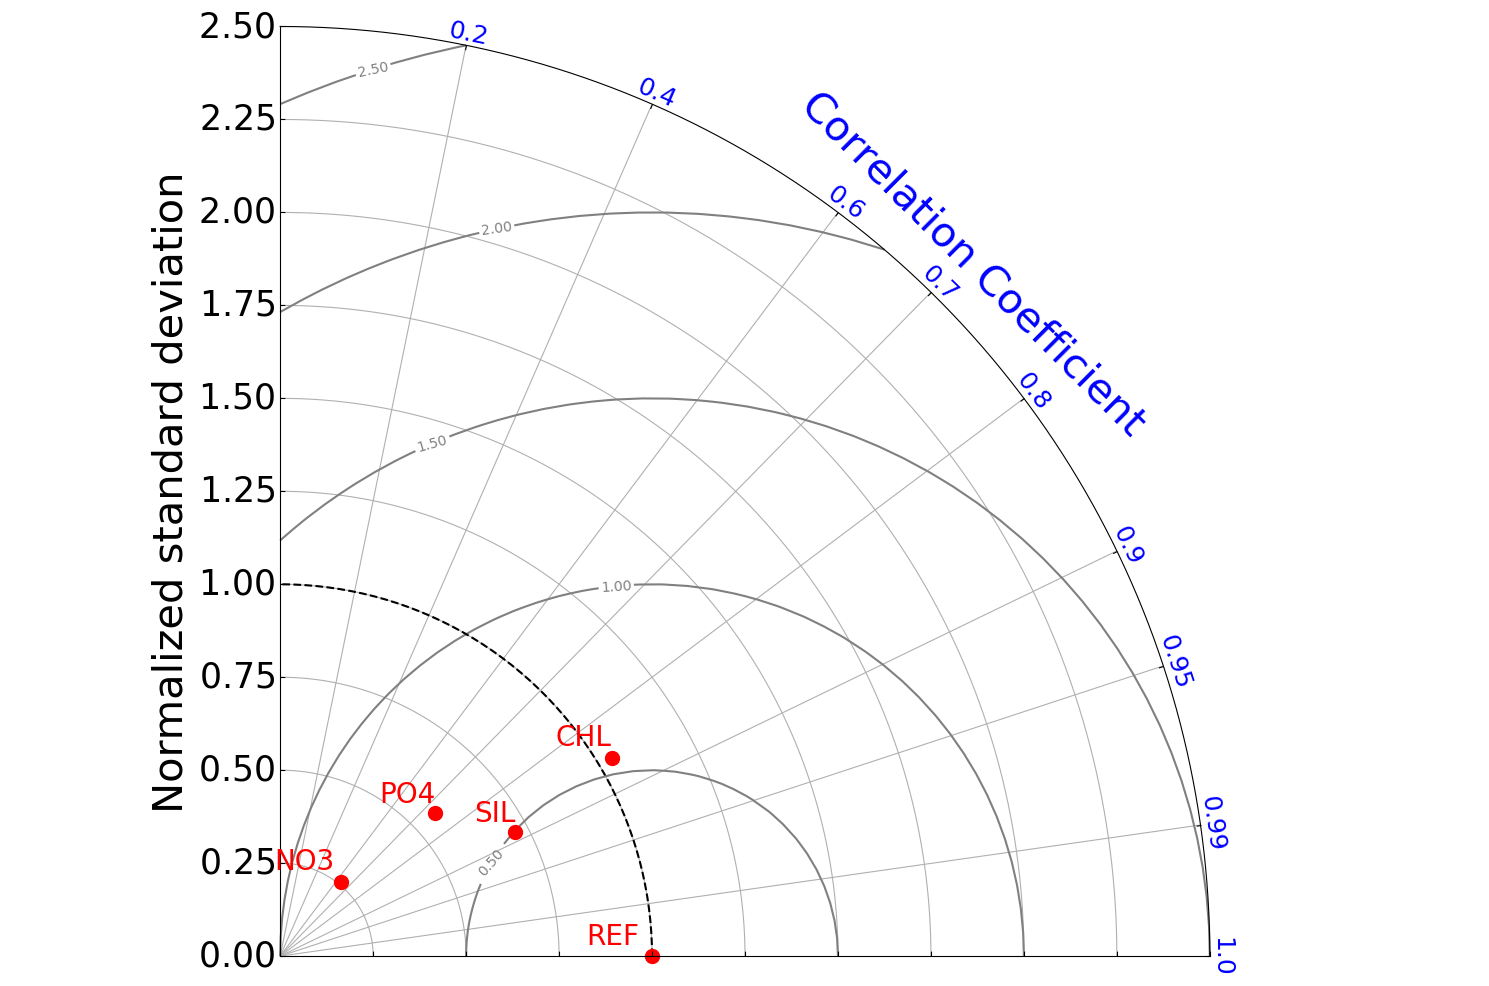

In [216]:
def make_plots(axs):
    plt.axis('off')
    dia=TaylorDiagram.TaylorDiagram(refnstd,
                                    fig=fig,
                                    rect=111,
                                    label='Reference',
                                    srange=(0,2.5),
                                    extend=False)
    dia.add_sample(nstdlogchl,
                   corrcoeflogchl,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogno3,
                   corrcoeflogno3,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogsioh4,
                   corrcoeflogsioh4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogpo4,
                   corrcoeflogpo4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_grid()
    contours=dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    plt.text(0.39,0.24,'CHL',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.20,0.11,'NO3',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.33,0.16,'SIL',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.27,0.18,'PO4',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.41,0.03,'REF',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.tight_layout()
with plt.style.context('mplstyles/taylor.mplstyle'):   
    # Plot
    fig=plt.figure(figsize=(15,10))
    ax=fig.add_subplot(111)
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_supmat_progress/taylor.png',dpi=1000)

## Plot: chlorophyll $a$ and phytoplankton biomass

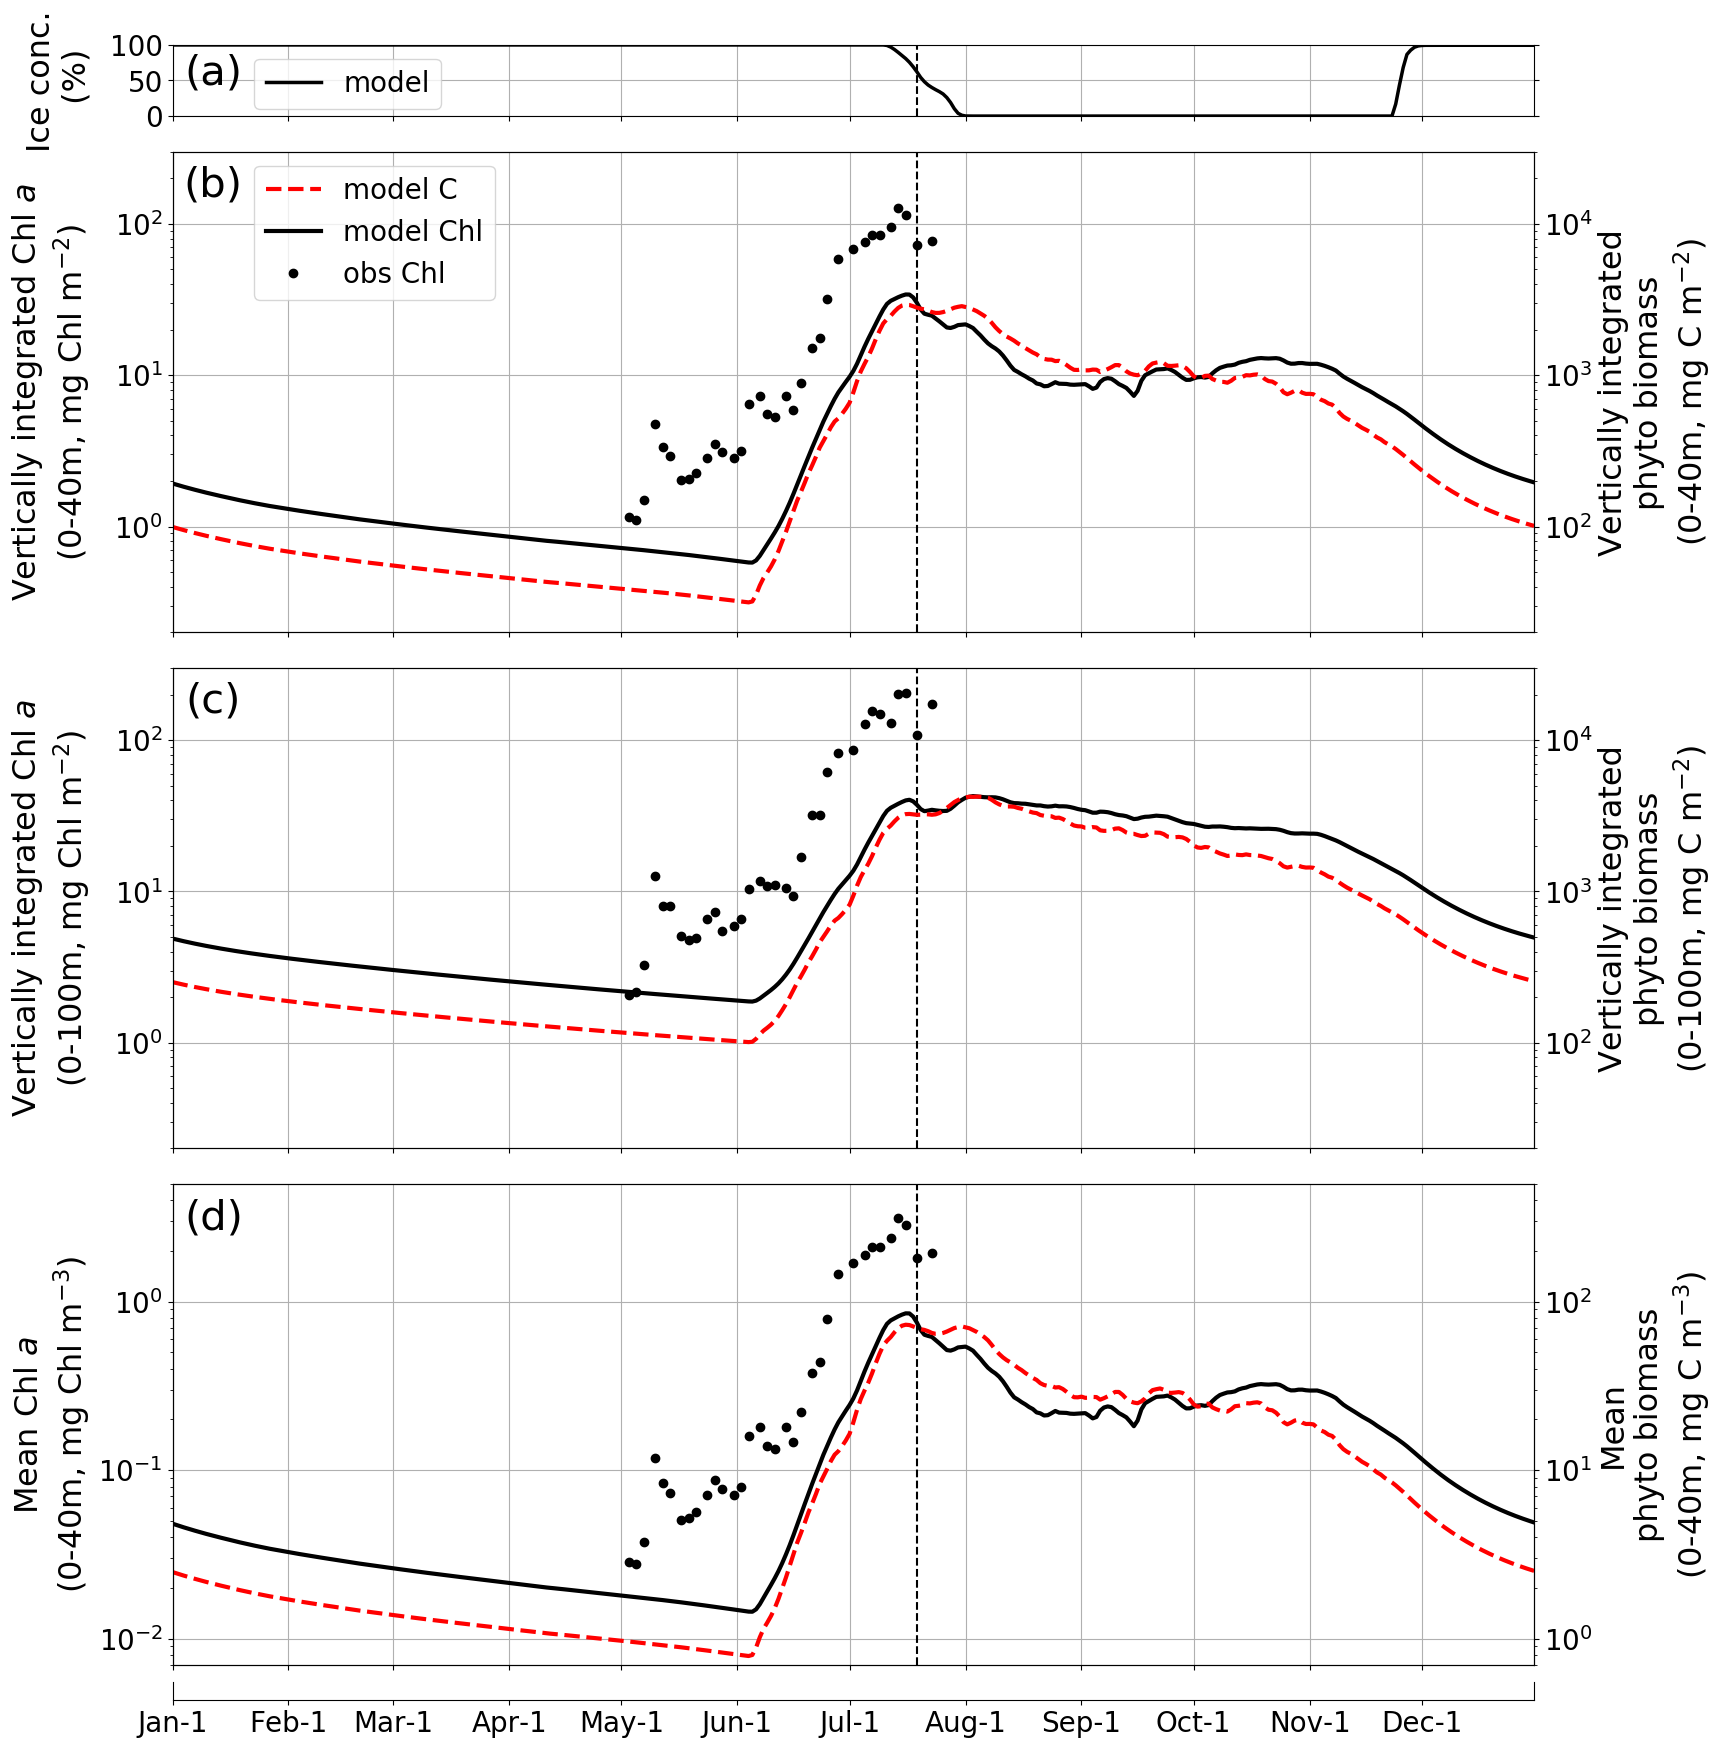

In [217]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- ICE CONCENTRATION
    ax=axs[0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)',bbox=box)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper left',bbox_to_anchor=(0.05,1.00))
    plt.text(0.03,0.6,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')
    
    # --- VERTICALLY INTEGRATED 0-40m
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_modvint40mchl,
               '-',lw=3,color='black',label='model Chl')
    h2=ax.plot(first_year,array1d_iT_obsvint40mchlHPLC,
               'o',markersize=6,color='black',label='obs Chl')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(2E-1,3E2)
    ax.set_ylabel('Vertically integrated Chl $a$\n'
                  '(0-40m, $\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.grid()
    axt = ax.twinx()
    # g C m^-2 -> mg C m^-2
    h3=axt.plot(first_year,array1d_iT_modvint40mphytobio*1E3,
                '--',lw=3,color='red',label='model C')
    axt.set_yscale('log')
    axt.set_ylim(*[100*l for l in ax.get_ylim()])
    axt.set_ylabel('Vertically integrated\n'
                  'phyto biomass\n'
                  '(0-40m, $\mathrm{ mg\ C\ m^{-2} }$)')
    # ref: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
    # answer by Paul
#     lns=h1+h2+h3
    lns=h3+h1+h2
    labs = [l.get_label() for l in lns]
    ax.legend(lns,labs,loc='upper left',bbox_to_anchor=(0.05,1.00))
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')
    
    # --- VERTICALLY INTEGRATED 0-100m
    ax=axs[2]
    h1=ax.plot(first_year,array1d_iT_modvintchl,
               '-',lw=3,color='black',label='model Chl')
    h2=ax.plot(first_year,array1d_iT_obsvintchlHPLC,
               'o',markersize=6,color='black',label='obs Chl')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(2E-1,3E2)
    ax.set_ylabel('Vertically integrated Chl $a$\n'
                  '(0-100m, $\mathrm{ mg\ Chl\ m^{-2} }$)')
    ax.grid()
    axt = ax.twinx()
    # g C m^-2 -> mg C m^-2
    h3=axt.plot(first_year,array1d_iT_modvintphytobio*1E3,
                '--',lw=3,color='red',label='model C')
    axt.set_yscale('log')
    axt.set_ylim(*[100*l for l in ax.get_ylim()])
    axt.set_ylabel('Vertically integrated\n'
                  'phyto biomass\n'
                  '(0-100m, $\mathrm{ mg\ C\ m^{-2} }$)')
    plt.text(0.03,0.93,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')
    
    # --- MEAN 0-40m
    ax=axs[3]
    h1=ax.plot(first_year,array1d_iT_modmeanchl,
               '-',lw=3,color='black',label='model Chl')
    h2=ax.plot(first_year,array1d_iT_obsmeanchlHPLC,
               'o',markersize=6,color='black',label='obs Chl')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(7E-3,5E0)
    ax.set_ylabel('Mean Chl $a$\n'
                  '(0-40m, $\mathrm{ mg\ Chl\ m^{-3} }$)')
    ax.grid()
    axt = ax.twinx()
    # g C m^-3 -> mg C m^-3
    h3=axt.plot(first_year,array1d_iT_modmeanphytobio*1E3,
                '--',lw=3,color='red',label='model C')
    axt.set_yscale('log')
    axt.set_ylim(*[100*l for l in ax.get_ylim()])
    axt.set_ylabel('Mean\n'
                  'phyto biomass\n'
                  '(0-40m, $\mathrm{ mg\ C\ m^{-3} }$)')
    plt.text(0.03,0.93,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[4]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.92  ,0.74,0.04])
    axs[1].set_position( [0.13,0.63  ,0.74,0.27])
    axs[2].set_position( [0.13,0.34  ,0.74,0.27])
    axs[3].set_position( [0.13,0.05  ,0.74,0.27])
    axs[4].set_position( [0.13,0.03  ,0.74,0.01])

with plt.style.context('mplstyles/vint40m.vint100m.mean40m.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(nrows=5,ncols=1,figsize=(18.4,17.8))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_supmat_progress/chl.bio.png',dpi=1000)

## Plot: accumulation rate for Qikiqtarjuaq 2016

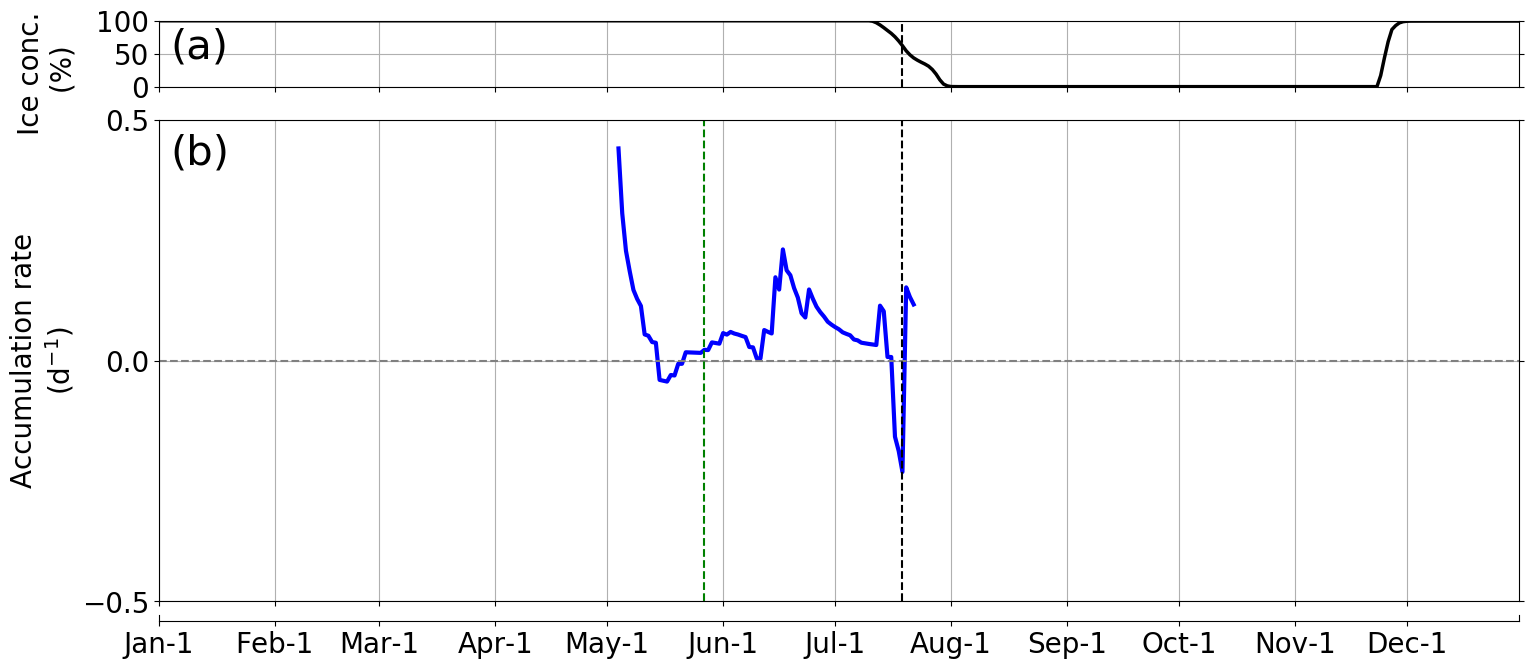

In [218]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- ICE CONCENTRATIONS
    ax=axs[0]
    h1=ax.plot(first_year,ice*100,'k-',lw=2.5,label='model')
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks([0,50,100])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n (%)')
    mpl.axis.Axis.set_label_coords(ax.yaxis,-0.06,0.20)
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.60,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_r2016,'-',color='blue',lw=3)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(-0.5,1.0,0.5))
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(-0.5,0.5)
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.plot(xlims,[0,0],'k--',color='gray')
    ax.grid()
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding the vertical line at start of bloom development
    ax.axvline(tI-1,color='green',linestyle='--')
    # adding the vertical line at 15% of observed ice
    ax.axvline(obs_breakup,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.13,0.88  ,0.85,0.10])
    axs[1].set_position( [0.13,0.10  ,0.85,0.73])
    axs[2].set_position( [0.13,0.07  ,0.85,0.01])
    
with plt.style.context('mplstyles/exp.mplstyle'):  
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16,6.6))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('figures_supmat_progress/r.png',dpi=1000)